
**Phase 1 — Data Preparation and Preprocessing**



In [1]:
# Workspace setup: folder structure for storing raw, interim, and cleaned data
!mkdir -p data/raw data/interim data/clean notebooks

In [2]:
!unzip data/raw/ciao_with_rating_timestamp_txt.zip -d data/raw/

Archive:  data/raw/ciao_with_rating_timestamp_txt.zip
   creating: data/raw/ciao_with_rating_timestamp_txt/
  inflating: data/raw/ciao_with_rating_timestamp_txt/rating_with_timestamp.txt  
  inflating: data/raw/ciao_with_rating_timestamp_txt/trust.txt  


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Unzip and extract dataset archives
!apt-get install -y unrar
!unrar x data/raw/epinions_with_timestamps_11.rar data/raw/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from data/raw/epinions_with_timestamps_11.rar

Creating    data/raw/epinions_with_timestamps_11                      OK
Extracting  data/raw/epinions_with_timestamps_11/epinion_trust_with_timestamp.mat      13%  OK 
Extracting  data/raw/epinions_with_timestamps_11/rating_with_timestamp.mat      14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 6

In [10]:
# Checking if dataset files have been extracted correctly
!ls -lh data/raw/

total 4.7M
drwxr-xr-x 2 root root 4.0K Jul 27  2012 ciao_with_rating_timestamp_txt
-rw-r--r-- 1 root root 551K Dec  9 14:03 ciao_with_rating_timestamp_txt.zip
drwxr-xr-x 2 root root 4.0K Oct 24  2012 epinions_with_timestamps_11
-rw-r--r-- 1 root root 4.1M Dec  9 14:05 epinions_with_timestamps_11.rar


In [11]:
!ls -lh data/raw/ciao_with_rating_timestamp_txt
!ls -lh data/raw/epinions_with_timestamps_11

total 5.3M
-rw-r--r-- 1 root root 3.4M Jul 27  2012 rating_with_timestamp.txt
-rw-r--r-- 1 root root 1.9M Jul 27  2012 trust.txt
total 4.2M
-rw-r--r-- 1 root root 583K Jul 25  2012 epinion_trust_with_timestamp.mat
-rw-r--r-- 1 root root 3.6M Jan 28  2012 rating_with_timestamp.mat


**STEP 1-Load & Inspect the Ciao Dataset**

In [12]:
import pandas as pd

#   Loading trust network  (user–user edges)
trust = pd.read_csv(
    "data/raw/ciao_with_rating_timestamp_txt/trust.txt",
    sep=r"\s+", header=None, names=["user", "friend"], engine="python"
)

#   Loading user–item ratings  (user, item, rating, timestamp)
ratings = pd.read_csv(
    "data/raw/ciao_with_rating_timestamp_txt/rating_with_timestamp.txt",
    sep=r"\s+", header=None, names=["user", "item", "rating", "timestamp"],
    usecols=[0, 1, 2, 3], engine="python"
)

#   Converting datatypes for easier processing
trust = trust.astype({"user": "int32", "friend": "int32"})
ratings = ratings.astype({
    "user": "int32",
    "item": "int32",
    "rating": "float32",
    "timestamp": "float64"
})

#   Inspecting basic info
print(" Trust edges:", trust.shape)
print(" Ratings:", ratings.shape)

print("\n Trust sample:")
print(trust.head())

print("\n Ratings sample:")
print(ratings.head())

#  Descriptive checks
print("\nUnique users in trust:", trust['user'].nunique())
print("Unique users in ratings:", ratings['user'].nunique())
print("Unique items in ratings:", ratings['item'].nunique())
print("Missing values per column:\n", ratings.isna().sum())


 Trust edges: (57544, 2)
 Ratings: (36065, 4)

 Trust sample:
   user  friend
0     1       2
1     1       3
2     1       4
3     1       5
4     1       6

 Ratings sample:
   user  item  rating  timestamp
0     1     1     1.0        5.0
1     1     2     1.0        5.0
2     1     3     1.0        5.0
3     1     4     1.0        5.0
4     1     5     1.0        5.0

Unique users in trust: 2190
Unique users in ratings: 2248
Unique items in ratings: 16861
Missing values per column:
 user         0
item         0
rating       0
timestamp    0
dtype: int64


**STEP 2-Data Cleaning & Alignment**

In [13]:
#  Removing self-loops and duplicate trust edges
trust = trust[trust["user"] != trust["friend"]].drop_duplicates().reset_index(drop=True)

#  Removing any invalid and missing ratings
ratings = ratings.dropna(subset=["rating"])
ratings = ratings[ratings["rating"] > 0]

#  Normalizing ratings to 0–1 range
ratings["rating_norm"] = (
    (ratings["rating"] - ratings["rating"].min())
    / (ratings["rating"].max() - ratings["rating"].min())
)

#  Keeping only users that appear in both trust & rating
#  Keeping only users that:
#    - have at least one rating, and
#    - appear anywhere in the trust network (as user or friend)y

all_trust_users = set(trust["user"].unique()).union(set(trust["friend"].unique()))
valid_users = set(ratings["user"].unique()).intersection(all_trust_users)

trust = trust[
    trust["user"].isin(valid_users) & trust["friend"].isin(valid_users)
].reset_index(drop=True)
ratings = ratings[ratings["user"].isin(valid_users)].reset_index(drop=True)

#  Exploratory Data Analysis (EDA) after cleaning
summary = {
    "unique_users_after_cleaning": len(valid_users),
    "unique_items_after_cleaning": ratings["item"].nunique(),
    "n_ratings_after_cleaning": len(ratings),
    "n_trust_edges_after_cleaning": len(trust),
    "avg_user_degree_in_trust": trust.groupby("user").size().mean(),
    "avg_interactions_per_user": ratings.groupby("user").size().mean()
}

print("\n Cleaned Data Summary:")
for k, v in summary.items():
    print(f"{k:35s} : {v:.2f}" if isinstance(v, (int, float)) else f"{k:35s} : {v}")

#  Saving cleaned CSVs
!mkdir -p data/clean
trust.to_csv("data/clean/ciao_trust_clean.csv", index=False)
ratings.to_csv("data/clean/ciao_ratings_clean.csv", index=False)

print("\n Step complete — cleaned datasets saved in data/clean/")



 Cleaned Data Summary:
unique_users_after_cleaning         : 2215.00
unique_items_after_cleaning         : 16790.00
n_ratings_after_cleaning            : 35550.00
n_trust_edges_after_cleaning        : 52721.00
avg_user_degree_in_trust            : 25.57
avg_interactions_per_user           : 16.05

 Step complete — cleaned datasets saved in data/clean/


In [18]:
# ---------- CIAO DATASET LISTS ----------

# Unique users (from ratings + trust)
ciao_users = sorted(
    set(ratings["user"].unique())
    .union(set(trust["user"].unique()))
    .union(set(trust["friend"].unique()))
)

# Unique items (from ratings only)
ciao_items = sorted(ratings["item"].unique())

# Rating entries: (user, item, rating)
ciao_rating_list = ratings[["user", "item", "rating"]].values.tolist()

# Trust edges: (user, friend)
ciao_trust_list = trust[["user", "friend"]].values.tolist()


# ---------- PRINT SUMMARY + SAMPLES ----------
print("CIAO USERS:", len(ciao_users))
print("CIAO ITEMS:", len(ciao_items))
print("CIAO RATINGS:", len(ciao_rating_list))
print("CIAO TRUST EDGES:", len(ciao_trust_list))

print("\nSample Users:", ciao_users[:10])
print("Sample Items:", ciao_items[:10])
print("Sample Ratings:", ciao_rating_list[:5])
print("Sample Trust Edges:", ciao_trust_list[:5])

CIAO USERS: 2215
CIAO ITEMS: 16790
CIAO RATINGS: 35550
CIAO TRUST EDGES: 52721

Sample Users: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11)]
Sample Items: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10)]
Sample Ratings: [[1.0, 1.0, 1.0], [1.0, 2.0, 1.0], [1.0, 3.0, 1.0], [1.0, 4.0, 1.0], [1.0, 5.0, 1.0]]
Sample Trust Edges: [[1, 2], [1, 3], [1, 4], [1, 6], [1, 7]]


**Ratings per User (Ciao)**

The majority of users rate only a few items. A small fraction is highly active. This long tail structure means the dataset is sparse and benefits from social signal propagation.

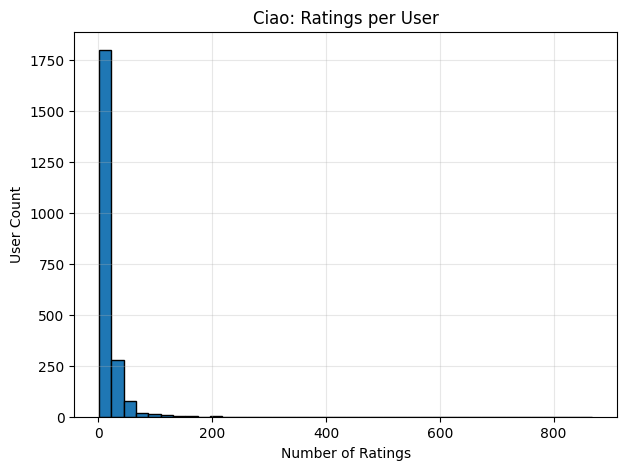

In [35]:
ratings_per_user = ratings.groupby("user").size()

plt.figure(figsize=(7,5))
plt.hist(ratings_per_user, bins=40, edgecolor='black')
plt.title("Ciao: Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("User Count")
plt.grid(alpha=0.3)
plt.show()

**Trust Degree Distribution (Ciao)**

Most users have very few trust connections, while a small group has many. This creates a sparse but informative social graph that the model can use to reduce cold start problems.

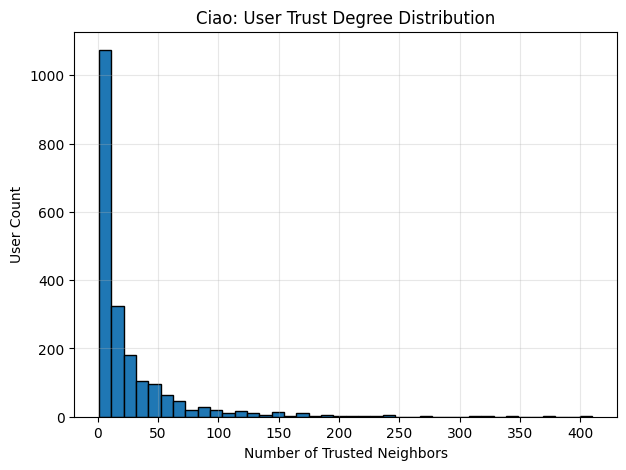

In [36]:
import numpy as np
import matplotlib.pyplot as plt

degrees = trust.groupby("user").size()

plt.figure(figsize=(7,5))
plt.hist(degrees, bins=40, edgecolor='black')
plt.title("Ciao: User Trust Degree Distribution")
plt.xlabel("Number of Trusted Neighbors")
plt.ylabel("User Count")
plt.grid(alpha=0.3)
plt.show()

In [14]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.sparse as sp
from tqdm import tqdm

print("Libraries loaded")

Libraries loaded


In [15]:
import os

for root, dirs, files in os.walk("/content", topdown=True):
    for name in files:
        if name.endswith(".csv"):
            print(os.path.join(root, name))


/content/drive/MyDrive/wdc-03-isi01-quotas.csv
/content/drive/MyDrive/wdc-03-isi03-quotas.csv
/content/drive/MyDrive/10-30-2023_staas_showback (1).csv
/content/drive/MyDrive/10-30-2023_staas_showback.csv
/content/drive/MyDrive/TableExportData_2023_06_16_12_36_16 (1).csv
/content/drive/MyDrive/TableExportData_2023_06_16_12_36_16.csv
/content/data/clean/ciao_trust_clean.csv
/content/data/clean/ciao_ratings_clean.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv


In [ ]:
ratings_df = pd.read_csv("/content/data/clean/ciao_ratings_clean.csv")
trust_df   = pd.read_csv("/content/data/clean/ciao_trust_clean.csv")

print("Ratings shape:", ratings_df.shape)
print("Trust shape:", trust_df.shape)
ratings_df.head(), trust_df.head()


Ratings shape: (35550, 5)
Trust shape: (52721, 2)


(   user  item  rating  timestamp  rating_norm
 0     1     1     1.0        5.0          0.0
 1     1     2     1.0        5.0          0.0
 2     1     3     1.0        5.0          0.0
 3     1     4     1.0        5.0          0.0
 4     1     5     1.0        5.0          0.0,
    user  friend
 0     1       2
 1     1       3
 2     1       4
 3     1       6
 4     1       7)

In [ ]:
ratings_df = pd.read_csv("/content/data/clean/ciao_ratings_clean.csv")
trust_df   = pd.read_csv("/content/data/clean/ciao_trust_clean.csv")

print("Ratings columns:", ratings_df.columns.tolist())
print("Trust columns:", trust_df.columns.tolist())

Ratings columns: ['user', 'item', 'rating', 'timestamp', 'rating_norm']
Trust columns: ['user', 'friend']


In [ ]:
# Unique users come from BOTH trust network and ratings file
unique_users = sorted(
    list(
        set(ratings_df["user"]).union(set(trust_df["user"])).union(set(trust_df["friend"]))
    )
)

unique_items = sorted(ratings_df["item"].unique())

user2idx = {u: i for i, u in enumerate(unique_users)}
item2idx = {it: j for j, it in enumerate(unique_items)}

ratings_df["user_idx"] = ratings_df["user"].map(user2idx)
ratings_df["item_idx"] = ratings_df["item"].map(item2idx)

trust_df["u_idx"] = trust_df["user"].map(user2idx)
trust_df["v_idx"] = trust_df["friend"].map(user2idx)

print("Total users:", len(unique_users))
print("Total items:", len(unique_items))


Total users: 2215
Total items: 16790


In [ ]:
num_users = len(unique_users)

row = trust_df["u_idx"].values
col = trust_df["v_idx"].values
data = np.ones(len(trust_df))

A = sp.coo_matrix((data, (row, col)), shape=(num_users, num_users))

print("A shape:", A.shape)
print("Edges:", A.nnz)

A shape: (2215, 2215)
Edges: 52721


In [ ]:
A = A + A.T
A[A > 1] = 1

print("Symmetrized A edges:", A.nnz)


Symmetrized A edges: 80244


In [ ]:
num_items = len(unique_items)

row = ratings_df["user_idx"].values
col = ratings_df["item_idx"].values
data = ratings_df["rating_norm"].values

R = sp.coo_matrix((data, (row, col)), shape=(num_users, num_items))

print("R shape:", R.shape)
print("Interactions:", R.nnz)


R shape: (2215, 16790)
Interactions: 35550


In [ ]:
print("===== STEP 2 COMPLETE =====")
print("Users:", num_users)
print("Items:", num_items)
print("A (social graph):", A.shape, "| edges:", A.nnz)
print("R (interaction matrix):", R.shape, "| interactions:", R.nnz)


===== STEP 2 COMPLETE =====
Users: 2215
Items: 16790
A (social graph): (2215, 2215) | edges: 80244
R (interaction matrix): (2215, 16790) | interactions: 35550


**PHASE 2-CORE MODEL DEVELOPMENT**

**STEP 1-Graph Based Denoising**

In [ ]:
# Step 3.1: Imports and device setup

import torch
import torch.nn as nn
import torch.optim as optim
import scipy.sparse as sp
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Step 3.2: Normalize adjacency matrix A and convert to torch sparse

def normalize_adj(adj):
    """
    Symmetric normalization: A_hat = D^{-1/2} (A + I) D^{-1/2}
    Returns a scipy sparse matrix.
    """
    adj = adj.tocsr()
    adj = adj + sp.eye(adj.shape[0], dtype=adj.dtype, format="csr")
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt @ adj @ D_inv_sqrt

A_norm = normalize_adj(A)

def scipy_to_torch_sparse(mat):
    """
    Convert scipy sparse matrix to torch.sparse_coo_tensor.
    """
    mat = mat.tocoo()
    indices = torch.from_numpy(
        np.vstack([mat.row, mat.col]).astype(np.int64)
    )
    values = torch.from_numpy(mat.data.astype(np.float32))
    shape = torch.Size(mat.shape)
    return torch.sparse_coo_tensor(indices, values, shape)

A_norm_torch = scipy_to_torch_sparse(A_norm).to(device)

print("Normalized adjacency ready. Shape:", A_norm_torch.shape)


Normalized adjacency ready. Shape: torch.Size([2215, 2215])


In [ ]:
# Step 3.3: Define GCN layer and Graph Autoencoder (GAE)

class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x, adj):
        """
        x: dense node features [N, in_dim]
        adj: normalized adjacency (sparse) [N, N]
        """
        x = torch.sparse.mm(adj, x)
        x = self.linear(x)
        return x

class GAE(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64, emb_dim=32):
        super().__init__()
        # Use node count as input dim because we will use identity features
        self.gc1 = GCNLayer(num_nodes, hidden_dim)
        self.gc2 = GCNLayer(hidden_dim, emb_dim)

    def encode(self, x, adj):
        h = self.gc1(x, adj)
        h = torch.relu(h)
        z = self.gc2(h, adj)
        return z

    def decode(self, z, edges_u, edges_v):
        """
        Inner-product decoder for a batch of node pairs.
        edges_u, edges_v: index tensors [batch_size]
        """
        z_u = z[edges_u]
        z_v = z[edges_v]
        scores = (z_u * z_v).sum(dim=1)
        return scores

    def forward(self, x, adj, edges_u, edges_v):
        z = self.encode(x, adj)
        scores = self.decode(z, edges_u, edges_v)
        return scores, z

# Identity node features (one-hot). For 2069 nodes this is fine.
X = torch.eye(num_users, dtype=torch.float32, device=device)

# Larger hidden and embedding dimensions for better capacity
model = GAE(num_nodes=num_users, hidden_dim=128, emb_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

print("GAE model initialized with hidden_dim=128 and emb_dim=64.")



GAE model initialized with hidden_dim=128 and emb_dim=64.


In [ ]:
# Step 3.4: Prepare positive and negative edge samples for training

# Use only upper triangle edges to avoid duplicates (for undirected graph)
A_triu = sp.triu(A, k=1).tocsr()
pos_u, pos_v = A_triu.nonzero()
num_pos = len(pos_u)

print("Number of positive training edges:", num_pos)

rng = np.random.default_rng(42)

# Build a set of existing edges (both directions) to avoid sampling them as negatives
existing_edges = set(zip(pos_u, pos_v)) | set(zip(pos_v, pos_u))

def sample_negative_edges(num_samples):
    """
    Randomly sample node pairs (u, v) that are not connected in the graph.
    """
    neg_u = []
    neg_v = []
    while len(neg_u) < num_samples:
        u = rng.integers(0, num_users)
        v = rng.integers(0, num_users)
        if u == v:
            continue
        if (u, v) in existing_edges:
            continue
        neg_u.append(u)
        neg_v.append(v)
    return np.array(neg_u), np.array(neg_v)


Number of positive training edges: 40122


In [ ]:
# Step 3.5: Train the GAE to reconstruct the adjacency matrix
num_epochs = 40
batch_size = 2048


pos_indices = np.arange(num_pos)

for epoch in range(num_epochs):
    np.random.shuffle(pos_indices)
    epoch_loss = 0.0

    for start in range(0, num_pos, batch_size):
        end = min(start + batch_size, num_pos)
        batch_pos = pos_indices[start:end]

        # Positive edges
        u_pos = pos_u[batch_pos]
        v_pos = pos_v[batch_pos]

        # Negative edges (same number as positives in this batch)
        u_neg, v_neg = sample_negative_edges(len(batch_pos))

        # Concatenate positives and negatives
        u_batch = np.concatenate([u_pos, u_neg])
        v_batch = np.concatenate([v_pos, v_neg])

        u_batch = torch.from_numpy(u_batch).long().to(device)
        v_batch = torch.from_numpy(v_batch).long().to(device)

        # Labels: 1 for positive edges, 0 for negative
        labels = torch.cat([
            torch.ones(len(batch_pos), device=device),
            torch.zeros(len(batch_pos), device=device)
        ])

        optimizer.zero_grad()
        scores, z = model(X, A_norm_torch, u_batch, v_batch)
        loss = criterion(scores, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(batch_pos)

    avg_loss = epoch_loss / num_pos
    print(f"Epoch {epoch+1}/{num_epochs}, loss = {avg_loss:.4f}")

print("GAE training complete.")


Epoch 1/40, loss = 0.6119
Epoch 2/40, loss = 0.5463
Epoch 3/40, loss = 0.5113
Epoch 4/40, loss = 0.4927
Epoch 5/40, loss = 0.4878
Epoch 6/40, loss = 0.4896
Epoch 7/40, loss = 0.4894
Epoch 8/40, loss = 0.4891
Epoch 9/40, loss = 0.4889
Epoch 10/40, loss = 0.4835
Epoch 11/40, loss = 0.4836
Epoch 12/40, loss = 0.4772
Epoch 13/40, loss = 0.4718
Epoch 14/40, loss = 0.4686
Epoch 15/40, loss = 0.4659
Epoch 16/40, loss = 0.4636
Epoch 17/40, loss = 0.4628
Epoch 18/40, loss = 0.4636
Epoch 19/40, loss = 0.4619
Epoch 20/40, loss = 0.4631
Epoch 21/40, loss = 0.4618
Epoch 22/40, loss = 0.4598
Epoch 23/40, loss = 0.4615
Epoch 24/40, loss = 0.4620
Epoch 25/40, loss = 0.4563
Epoch 26/40, loss = 0.4563
Epoch 27/40, loss = 0.4554
Epoch 28/40, loss = 0.4535
Epoch 29/40, loss = 0.4560
Epoch 30/40, loss = 0.4555
Epoch 31/40, loss = 0.4567
Epoch 32/40, loss = 0.4536
Epoch 33/40, loss = 0.4535
Epoch 34/40, loss = 0.4523
Epoch 35/40, loss = 0.4530
Epoch 36/40, loss = 0.4539
Epoch 37/40, loss = 0.4502
Epoch 38/4

In [ ]:
# Step 3.6: Build denoised adjacency A' using learned embeddings

model.eval()
with torch.no_grad():
    Z = model.encode(X, A_norm_torch)   # shape: [num_users, emb_dim]

Z = Z.cpu()

# Compute similarity matrix via inner product
sim = torch.matmul(Z, Z.t())  # [N, N]
# Remove self-similarity
sim = sim - torch.diag_embed(torch.diag(sim))

# Build a sparse graph by keeping top-k neighbors per node
k = 10  # can be tuned based on experiments

rows = []
cols = []
data = []

for i in range(num_users):
    # top-k similar nodes for node i
    vals, idxs = torch.topk(sim[i], k)
    idxs = idxs.numpy()
    vals = vals.numpy()
    for j, s in zip(idxs, vals):
        if s > 0:
            rows.append(i)
            cols.append(int(j))
            data.append(float(s))

A_denoised = sp.coo_matrix(
    (data, (rows, cols)),
    shape=(num_users, num_users)
)

# Make the denoised graph symmetric
A_denoised = A_denoised + A_denoised.T
A_denoised.data = (A_denoised.data - A_denoised.data.min()) / (A_denoised.data.max() - A_denoised.data.min() + 1e-8)
A_denoised = A_denoised.tocoo()

print("Original A edges:", A.nnz)
print("Denoised A' edges:", A_denoised.nnz)
print("Denoised adjacency A' constructed.")


Original A edges: 80244
Denoised A' edges: 43418
Denoised adjacency A' constructed.


In [ ]:
degrees = np.array(A_denoised.sum(1)).flatten()
print("Average weighted degree in A':", degrees.mean())


Average weighted degree in A': 2.3981435492863827


In [ ]:
A_bin = A_denoised.copy()
A_bin.data = np.ones_like(A_bin.data)  # binarize weights
avg_unweighted_deg = np.mean(A_bin.sum(axis=1))
print("Average unweighted degree in A':", avg_unweighted_deg)


Average unweighted degree in A': 19.601805869074493


In [ ]:
deg_unweighted = np.array(A_bin.sum(axis=1)).flatten()
isolated_frac = np.mean(deg_unweighted == 0)
print("Fraction of isolated users:", isolated_frac)


Fraction of isolated users: 0.0


In [ ]:
print((A_denoised != A_denoised.T).nnz)
# Should be 0 or very close to 0


0


In [ ]:
print("Min weight:", A_denoised.data.min())
print("Max weight:", A_denoised.data.max())
print("Mean weight:", A_denoised.data.mean())


Min weight: 0.0
Max weight: 0.9999999996212123
Mean weight: 0.12234299050323225


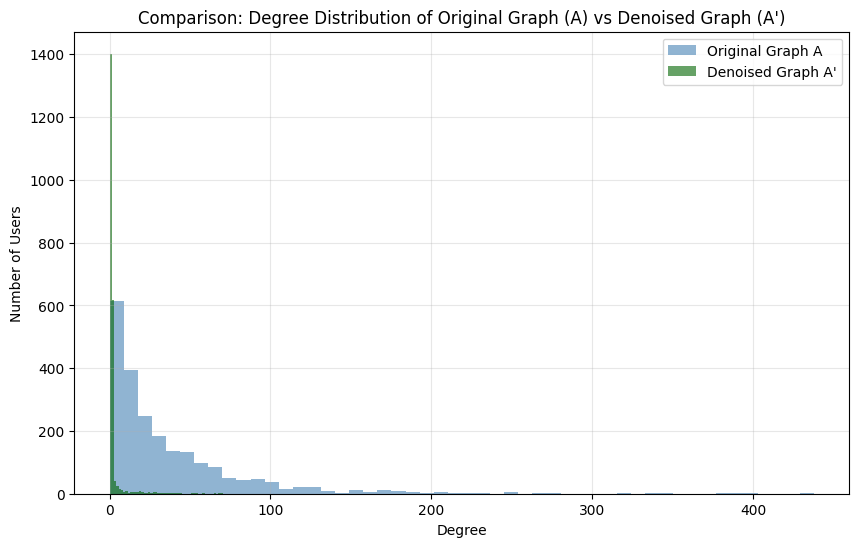

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute degrees
deg_A = np.array(A.sum(1)).flatten()
deg_Ad = np.array(A_denoised.sum(1)).flatten()

plt.figure(figsize=(10,6))

# Plot histograms
plt.hist(deg_A, bins=50, alpha=0.6, label="Original Graph A", color="steelblue")
plt.hist(deg_Ad, bins=50, alpha=0.6, label="Denoised Graph A'", color="darkgreen")

# Labels and title
plt.title("Comparison: Degree Distribution of Original Graph (A) vs Denoised Graph (A')")
plt.xlabel("Degree")
plt.ylabel("Number of Users")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


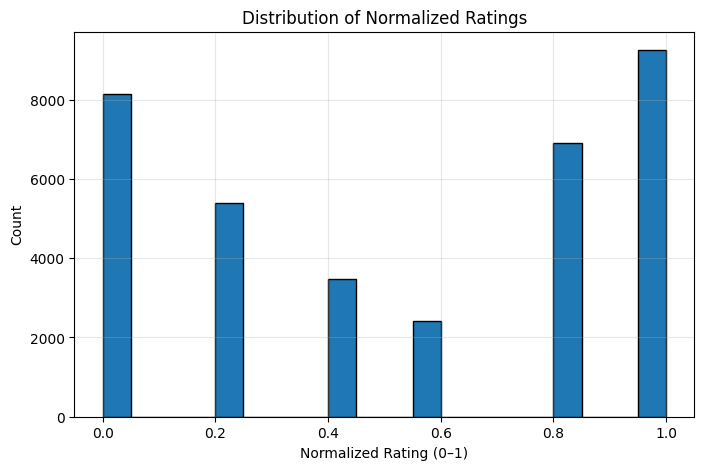

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(ratings_df['rating_norm'], bins=20, edgecolor='black')
plt.title("Distribution of Normalized Ratings")
plt.xlabel("Normalized Rating (0–1)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


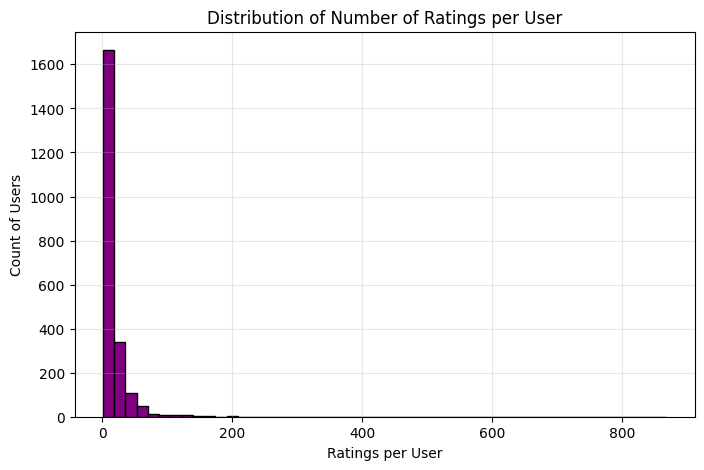

In [ ]:
ratings_per_user = ratings_df.groupby("user").size()

plt.figure(figsize=(8,5))
plt.hist(ratings_per_user, bins=50, color='purple', edgecolor='black')
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Ratings per User")
plt.ylabel("Count of Users")
plt.grid(alpha=0.3)
plt.show()


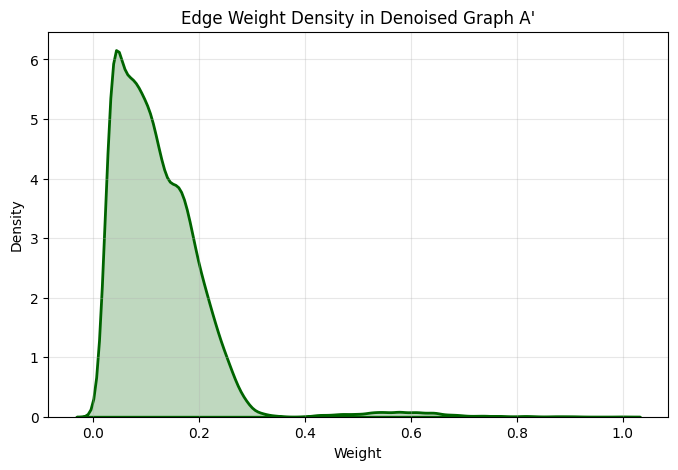

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.kdeplot(A_denoised.data, fill=True, linewidth=2, color="darkgreen")
plt.title("Edge Weight Density in Denoised Graph A'")
plt.xlabel("Weight")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()




**STEP 2-Normalize denoised adjacency A' and convert to torch sparse**

In [ ]:

A_denoised_norm = normalize_adj(A_denoised)
A_denoised_norm_torch = scipy_to_torch_sparse(A_denoised_norm).to(device)

print("A_denoised_norm_torch shape:", A_denoised_norm_torch.shape)

A_denoised_norm_torch shape: torch.Size([2215, 2215])


In [ ]:
#Build Train–Val–Test Splits for Ratings
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# Use user_idx, item_idx, rating_norm as supervised signal
interaction_array = ratings_df[["user_idx", "item_idx", "rating_norm"]].values

train_inter, temp_inter = train_test_split(
    interaction_array, test_size=0.2, random_state=42
)
val_inter, test_inter = train_test_split(
    temp_inter, test_size=0.5, random_state=42
)

def build_loader(array, batch_size=4096, shuffle=True):
    u = torch.from_numpy(array[:, 0].astype("int64"))
    i = torch.from_numpy(array[:, 1].astype("int64"))
    r = torch.from_numpy(array[:, 2].astype("float32"))
    dataset = TensorDataset(u, i, r)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = build_loader(train_inter, batch_size=4096, shuffle=True)
val_loader   = build_loader(val_inter,   batch_size=4096, shuffle=False)
test_loader  = build_loader(test_inter,  batch_size=4096, shuffle=False)

print("Train interactions:", len(train_inter))
print("Val interactions:", len(val_inter))
print("Test interactions:", len(test_inter))

Train interactions: 28440
Val interactions: 3555
Test interactions: 3555


In [ ]:
import torch.nn.functional as F

class SocialGCN(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, adj, alpha=0.5, dropout_p=0.2):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.emb_dim = emb_dim
        self.adj = adj  # normalized sparse A'
        self.alpha = alpha
        self.dropout_p = dropout_p
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        self.gc1 = GCNLayer(emb_dim, emb_dim)
        self.gc2 = GCNLayer(emb_dim, emb_dim)

        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)

    def propagate_users(self):
        h0 = self.user_emb.weight                     # U0

        # layer 1
        h1_nei = self.gc1(h0, self.adj)               # A' * U0 * W
        h1 = self.alpha * h0 + (1 - self.alpha) * h1_nei   # residual mix
        h1 = F.dropout(h1, p=self.dropout_p, training=self.training)
        h1 = torch.relu(h1)

        # layer 2
        h2_nei = self.gc2(h1, self.adj)
        h2 = self.alpha * h1 + (1 - self.alpha) * h2_nei
        h2 = F.dropout(h2, p=self.dropout_p, training=self.training)

        return h2

    def forward(self, user_idx, item_idx):
      user_z_all = self.propagate_users()
      u_z = user_z_all[user_idx]
      i_z = self.item_emb(item_idx)

      logits = (u_z * i_z).sum(dim=1)
      logits += self.user_bias(user_idx).squeeze(1)
      logits += self.item_bias(item_idx).squeeze(1)

      return logits, user_z_all


In [ ]:
#Initialize the model
emb_dim = 64   # You can tune this
social_gcn = SocialGCN(
    num_users=num_users,
    num_items=num_items,
    emb_dim=emb_dim,
    adj=A_denoised_norm_torch,
    alpha=0.6,
    dropout_p=0.25
).to(device)

gcn_optimizer = optim.Adam(social_gcn.parameters(), lr=0.005)
gcn_criterion = nn.MSELoss()  # rating_norm is in [0, 1]

print("SocialGCN initialized.")

SocialGCN initialized.


In [ ]:
# ============================================
# Step 4: Train SocialGCN with multi-negative BPR + MSE (Hybrid)
# ============================================

from collections import defaultdict
import numpy as np
import torch
import torch.nn.functional as F

# --------------------------------------------------
# 1) Build "seen" dictionary for negative sampling
#    (use TRAIN + VAL so negatives are truly unseen)
# --------------------------------------------------
user_seen = defaultdict(set)
for u, i, r_val in train_inter:
    user_seen[int(u)].add(int(i))
for u, i, r_val in val_inter:
    user_seen[int(u)].add(int(i))

all_items = np.arange(num_items)

def sample_negatives(u, n_neg=5):
    """
    Sample n_neg items that user u has NOT interacted with
    (according to train + val).
    """
    seen = user_seen[u]
    negs = []
    while len(negs) < n_neg:
        j = int(np.random.choice(all_items))
        if j not in seen:
            negs.append(j)
    return negs

def multi_bpr_loss(pos_logits, neg_logits):
    """
    BPR loss.
    pos_logits: (B,)
    neg_logits: (B, n_neg)
    """
    diff = pos_logits.unsqueeze(1) - neg_logits  # (B, n_neg)
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

def run_train_epoch_multi_bpr(model, loader, optimizer, n_neg=5, mse_lambda=0.1):
    """
    One training epoch with:
      - multi-negative BPR loss
      - + MSE term on positive scores vs normalized ratings
    """
    model.train()
    total_loss, total_count = 0.0, 0

    for u, i_pos, r_batch in loader:
        u = u.to(device)
        i_pos = i_pos.to(device)
        r_batch = r_batch.to(device)   # rating_norm in [0,1]

        # -------- sample negatives per user --------
        neg_items = [sample_negatives(int(x), n_neg=n_neg) for x in u.cpu().numpy()]
        i_neg = torch.tensor(neg_items, dtype=torch.long, device=device)  # (B, n_neg)

        optimizer.zero_grad()

        # -------- positive logits --------
        pos_logits, _ = model(u, i_pos)   # (B,)

        # -------- negative logits --------
        B, nN = i_neg.shape
        u_rep = u.unsqueeze(1).expand(B, nN).reshape(-1)  # (B*n_neg,)
        i_neg_flat = i_neg.reshape(-1)                    # (B*n_neg,)
        neg_logits_flat, _ = model(u_rep, i_neg_flat)     # (B*n_neg,)
        neg_logits = neg_logits_flat.reshape(B, nN)       # (B, n_neg)

        # -------- Hybrid loss: BPR + MSE --------
        bpr = multi_bpr_loss(pos_logits, neg_logits)
        preds_pos = torch.sigmoid(pos_logits)             # map to [0,1]
        mse = F.mse_loss(preds_pos, r_batch)              # match normalized rating

        loss = bpr + mse_lambda * mse
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(u)
        total_count += len(u)

    return total_loss / total_count

# --------------------------------------------------
# 2) Simple training loop (no early stopping inside)
# --------------------------------------------------
num_epochs_gnn = 30    # you can increase if needed
n_neg = 5
mse_lambda = 0.1

for epoch in range(1, num_epochs_gnn + 1):
    train_loss = run_train_epoch_multi_bpr(
        social_gcn,
        train_loader,
        gcn_optimizer,
        n_neg=n_neg,
        mse_lambda=mse_lambda,
    )
    print(f"[Epoch {epoch:02d}] train_loss = {train_loss:.4f}")

print("Step 4: BPR training complete.")


[Epoch 01] train_loss = 0.7066
[Epoch 02] train_loss = 0.6878
[Epoch 03] train_loss = 0.6199
[Epoch 04] train_loss = 0.5222
[Epoch 05] train_loss = 0.4929
[Epoch 06] train_loss = 0.4706
[Epoch 07] train_loss = 0.4583
[Epoch 08] train_loss = 0.4483
[Epoch 09] train_loss = 0.4374
[Epoch 10] train_loss = 0.4320
[Epoch 11] train_loss = 0.4259
[Epoch 12] train_loss = 0.4188
[Epoch 13] train_loss = 0.4149
[Epoch 14] train_loss = 0.4085
[Epoch 15] train_loss = 0.4046
[Epoch 16] train_loss = 0.3975
[Epoch 17] train_loss = 0.3930
[Epoch 18] train_loss = 0.3865
[Epoch 19] train_loss = 0.3780
[Epoch 20] train_loss = 0.3665
[Epoch 21] train_loss = 0.3507
[Epoch 22] train_loss = 0.3333
[Epoch 23] train_loss = 0.3075
[Epoch 24] train_loss = 0.2856
[Epoch 25] train_loss = 0.2577
[Epoch 26] train_loss = 0.2380
[Epoch 27] train_loss = 0.2171
[Epoch 28] train_loss = 0.2041
[Epoch 29] train_loss = 0.1916
[Epoch 30] train_loss = 0.1802
Step 4: BPR training complete.


In [ ]:
import numpy as np

thresh = 0.5
val_pos = val_inter[val_inter[:, 2] >= thresh]

print("Total val interactions:", len(val_inter))
print("Val positives (>=0.5):", len(val_pos))
print("Users with ≥1 positive in val:", len(np.unique(val_pos[:,0])))

# average positives per user
users = np.unique(val_inter[:,0])
avg_pos = np.mean([np.sum((val_inter[:,0]==u) & (val_inter[:,2]>=thresh)) for u in users])
print("Avg positives per user in val:", avg_pos)


Total val interactions: 3555
Val positives (>=0.5): 1854
Users with ≥1 positive in val: 821
Avg positives per user in val: 1.4045454545454545


In [ ]:
#Extract User and Item Embeddings
social_gcn.eval()
with torch.no_grad():
    user_embeddings = social_gcn.propagate_users().cpu().numpy()  # [num_users, emb_dim]
    item_embeddings = social_gcn.item_emb.weight.detach().cpu().numpy()  # [num_items, emb_dim]

print("User embeddings shape:", user_embeddings.shape)
print("Item embeddings shape:", item_embeddings.shape)

User embeddings shape: (2215, 64)
Item embeddings shape: (16790, 64)


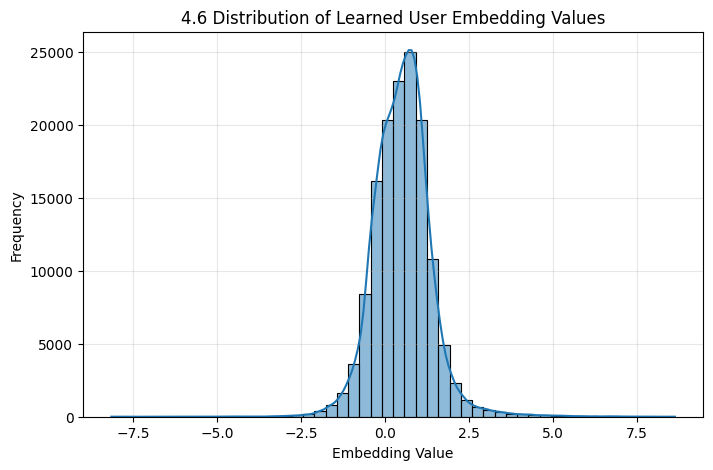

In [ ]:
#Distribution of User Embedding Values
flat = user_embeddings.flatten()

plt.figure(figsize=(8,5))
sns.histplot(flat, bins=50, kde=True)
plt.title("4.6 Distribution of Learned User Embedding Values")
plt.xlabel("Embedding Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


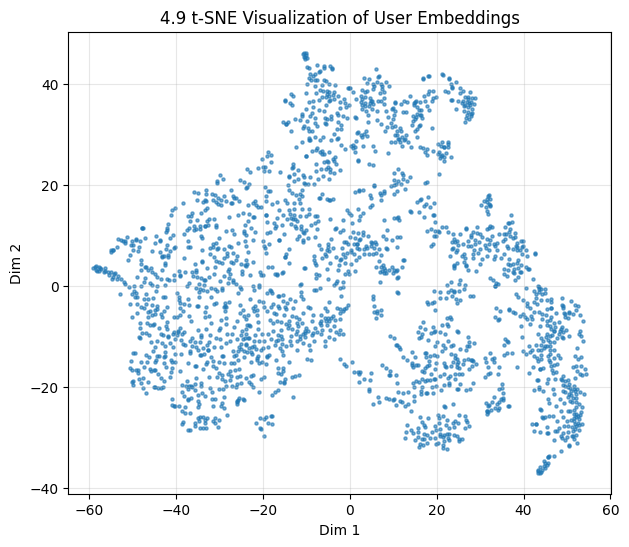

In [ ]:
# t-SNE Visualization of User Embeddings
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    n_iter=1500,
    random_state=42
)

emb_2d = tsne.fit_transform(user_embeddings)

plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=5, alpha=0.6)
plt.title("4.9 t-SNE Visualization of User Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(alpha=0.3)
plt.show()

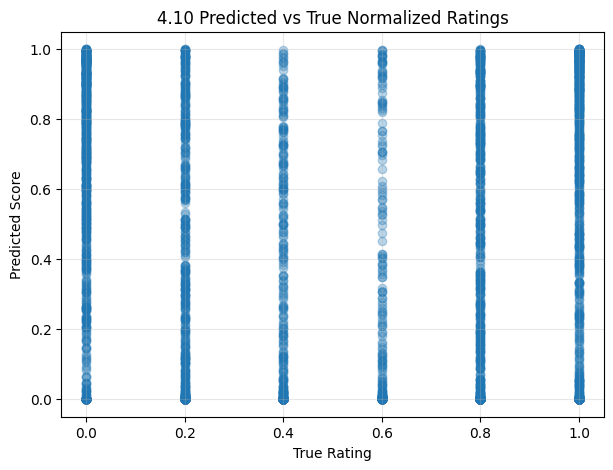

In [ ]:
#Predicted vs True Ratings (Calibration Plot)
all_preds, all_true = [], []

social_gcn.eval()
with torch.no_grad():
    for u,i,r in val_loader:
        scores, _ = social_gcn(u.to(device), i.to(device))
        preds = torch.sigmoid(scores).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(r.numpy())

plt.figure(figsize=(7,5))
plt.scatter(all_true, all_preds, alpha=0.3)
plt.title("4.10 Predicted vs True Normalized Ratings")
plt.xlabel("True Rating")
plt.ylabel("Predicted Score")
plt.grid(alpha=0.3)
plt.show()

**STEP 3-Recommendation Modeling (Link Prediction)**

In [ ]:
import numpy as np

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def get_user_scores(u_idx: int):
    """
    Compute predicted scores in [0, 1] for ALL items for a given user,
    using the learned embeddings from Step 4.
    """
    # user_embeddings: [num_users, emb_dim]
    # item_embeddings: [num_items, emb_dim]
    u_vec = user_embeddings[u_idx]              # (emb_dim,)
    # Raw scores = dot product between item vectors and this user's vector
    raw_scores = item_embeddings @ u_vec        # (num_items,)
    scores = sigmoid(raw_scores)                # map to [0, 1]
    return scores  # numpy array of length num_items

def recommend_for_user(u_idx: int, top_k: int = 10, exclude_seen: bool = True):
    """
    Recommend top_k items for a given user u_idx.

    - Uses the learned user & item embeddings.
    - Optionally excludes items that the user has already rated in ratings_df.

    Returns:
        List of (item_idx, predicted_score) sorted by score (desc).
    """
    scores = get_user_scores(u_idx)
    num_items = item_embeddings.shape[0]
    all_items = np.arange(num_items)

    if exclude_seen:
        seen_items = ratings_df.loc[
            ratings_df["user_idx"] == u_idx, "item_idx"
        ].values
        mask = np.ones(num_items, dtype=bool)
        mask[seen_items] = False
        candidate_items = all_items[mask]
        candidate_scores = scores[mask]
    else:
        candidate_items = all_items
        candidate_scores = scores

    # Sort candidates by score (highest first)
    order = np.argsort(-candidate_scores)
    top_items = candidate_items[order[:top_k]]
    top_scores = candidate_scores[order[:top_k]]

    return list(zip(top_items, top_scores))


# --- Example: show recommendations for a few users ---

for u in [0, 5, 10]:  # you can change these indices
    recs = recommend_for_user(u, top_k=10, exclude_seen=True)
    print(f"\nTop-10 recommendations for user_idx {u}:")
    for item_idx, score in recs:
        print(f"  item_idx {item_idx:4d}  |  predicted score = {score:.4f}")



Top-10 recommendations for user_idx 0:
  item_idx 2251  |  predicted score = 0.9899
  item_idx 4387  |  predicted score = 0.9899
  item_idx 1738  |  predicted score = 0.9840
  item_idx 2810  |  predicted score = 0.9807
  item_idx 1611  |  predicted score = 0.9786
  item_idx 2292  |  predicted score = 0.9737
  item_idx  784  |  predicted score = 0.9721
  item_idx 4224  |  predicted score = 0.9721
  item_idx  399  |  predicted score = 0.9718
  item_idx 2242  |  predicted score = 0.9711

Top-10 recommendations for user_idx 5:
  item_idx  898  |  predicted score = 0.9942
  item_idx  194  |  predicted score = 0.9904
  item_idx 5009  |  predicted score = 0.9900
  item_idx 4745  |  predicted score = 0.9898
  item_idx 6831  |  predicted score = 0.9892
  item_idx  302  |  predicted score = 0.9871
  item_idx  738  |  predicted score = 0.9859
  item_idx 4337  |  predicted score = 0.9857
  item_idx 4233  |  predicted score = 0.9852
  item_idx 3663  |  predicted score = 0.9851

Top-10 recommendati

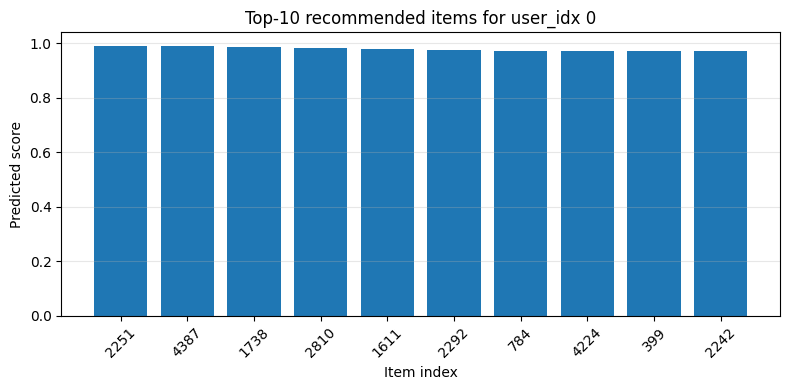

In [ ]:
import matplotlib.pyplot as plt

def plot_user_topk(u_idx: int, top_k: int = 10):
    """
    Bar plot of the predicted scores for the top-k items for a given user.
    """
    recs = recommend_for_user(u_idx, top_k=top_k, exclude_seen=True)
    item_ids = [i for (i, s) in recs]
    scores = [s for (i, s) in recs]

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(item_ids)), scores)
    plt.xticks(range(len(item_ids)), item_ids, rotation=45)
    plt.xlabel("Item index")
    plt.ylabel("Predicted score")
    plt.title(f"Top-{top_k} recommended items for user_idx {u_idx}")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example: visualize recommendations for one user
plot_user_topk(u_idx=0, top_k=10)


In [ ]:
import pandas as pd
import numpy as np

def tabulate_recommendations(u_idx: int, top_k: int = 10):
    recs = recommend_for_user(u_idx, top_k=top_k, exclude_seen=True)
    df = pd.DataFrame(recs, columns=["item_idx", "predicted_score"])
    df["rank"] = np.arange(1, len(df) + 1)

    # Optional: add raw item IDs if you have idx2item
    if "idx2item" in globals():
        df["raw_item_id"] = df["item_idx"].map(idx2item)

    # Optional: add a "seen?" column (should be False for all recommended)
    seen_items = set(ratings_df.loc[ratings_df["user_idx"] == u_idx, "item_idx"].values)
    df["already_rated"] = df["item_idx"].isin(seen_items)

    return df[["rank", "item_idx"] + (["raw_item_id"] if "idx2item" in globals() else []) + ["predicted_score", "already_rated"]]

# Example
tab_df = tabulate_recommendations(u_idx=0, top_k=20)
tab_df


,rank,item_idx,predicted_score,already_rated
0,1,2251,0.989913,False
1,2,4387,0.989898,False
2,3,1738,0.984011,False
3,4,2810,0.980702,False
4,5,1611,0.978591,False
5,6,2292,0.973703,False
6,7,784,0.972141,False
7,8,4224,0.972059,False
8,9,399,0.971770,False
9,10,2242,0.971100,False


Unique recommended items: 211 out of 3000


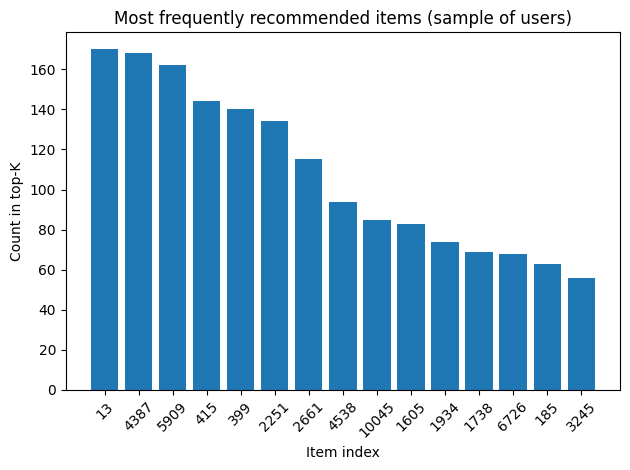

In [ ]:
from collections import Counter

def collect_topk_for_users(user_list, top_k=10):
    counter = Counter()
    for u in user_list:
        recs = recommend_for_user(u, top_k=top_k, exclude_seen=True)
        counter.update([i for i, s in recs])
    return counter

user_sample = np.random.choice(user_embeddings.shape[0], size=300, replace=False)
item_counter = collect_topk_for_users(user_sample, top_k=10)

unique_items = len(item_counter)
total_recs = 300 * 10
print("Unique recommended items:", unique_items, "out of", total_recs)

# plot top-15 most frequently recommended items
top_items = item_counter.most_common(15)
labels = [str(i) for i, c in top_items]
counts = [c for i, c in top_items]

import matplotlib.pyplot as plt
plt.figure()
plt.bar(labels, counts)
plt.xlabel("Item index")
plt.ylabel("Count in top-K")
plt.title("Most frequently recommended items (sample of users)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


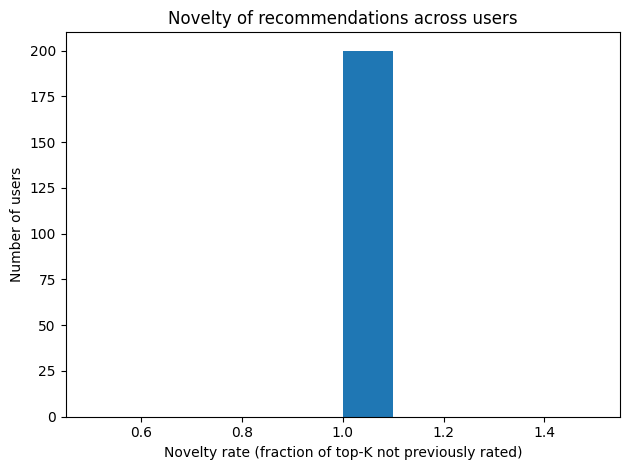

Average novelty rate: 1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def novelty_rate_for_user(u_idx, top_k=10):
    recs = recommend_for_user(u_idx, top_k=top_k, exclude_seen=True)
    rec_items = {i for i, s in recs}
    seen_items = set(ratings_df.loc[ratings_df["user_idx"] == u_idx, "item_idx"].values)
    # With exclude_seen=True this should be 1.0 always,
    # but if you ever set exclude_seen=False, this measures novelty.
    return 1.0 - len(rec_items & seen_items) / top_k

# sample users for speed
user_sample = np.random.choice(user_embeddings.shape[0], size=200, replace=False)
novelty_rates = [novelty_rate_for_user(u, top_k=10) for u in user_sample]

plt.figure()
plt.hist(novelty_rates, bins=10)
plt.xlabel("Novelty rate (fraction of top-K not previously rated)")
plt.ylabel("Number of users")
plt.title("Novelty of recommendations across users")
plt.tight_layout()
plt.show()

print("Average novelty rate:", np.mean(novelty_rates))


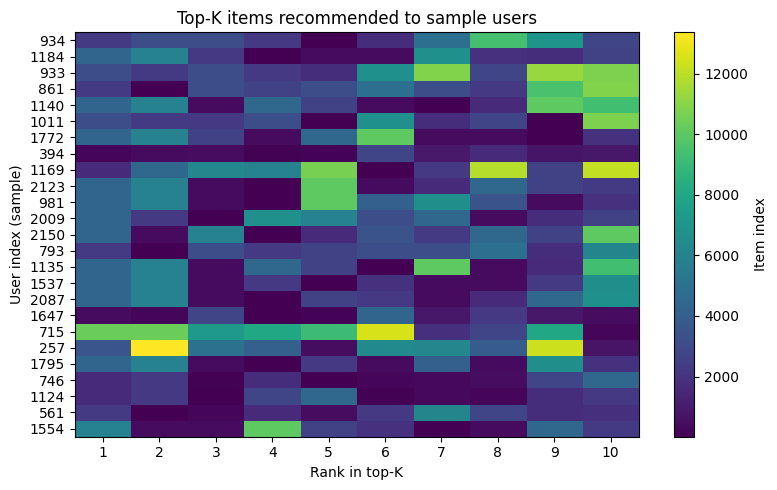

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# take a small sample so the heatmap is readable
user_sample = np.random.choice(user_embeddings.shape[0], size=25, replace=False)

top_k = 10
heat_items = []
for u in user_sample:
    recs = recommend_for_user(u, top_k=top_k, exclude_seen=True)
    heat_items.append([i for i, s in recs])

heat_items = np.array(heat_items)  # shape [25, 10]

plt.figure(figsize=(8, 5))
plt.imshow(heat_items, aspect="auto")
plt.colorbar(label="Item index")
plt.yticks(range(len(user_sample)), user_sample)
plt.xticks(range(top_k), range(1, top_k+1))
plt.xlabel("Rank in top-K")
plt.ylabel("User index (sample)")
plt.title("Top-K items recommended to sample users")
plt.tight_layout()
plt.show()


In [ ]:
norms = np.linalg.norm(item_embeddings, axis=1)
top_norm_items = norms.argsort()[-10:][::-1]
top_norm_items



array([5964, 3513, 5977, 5986, 5991, 5934, 5951, 5926, 4082, 7082])

In [ ]:
social_gcn.eval()
with torch.no_grad():
    user_embeddings = social_gcn.propagate_users().cpu().numpy()
    item_embeddings = social_gcn.item_emb.weight.detach().cpu().numpy()

print("user_embeddings:", user_embeddings.shape)
print("item_embeddings:", item_embeddings.shape)


user_embeddings: (2215, 64)
item_embeddings: (16790, 64)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

sample_users = np.random.choice(num_users, size=300, replace=False)
sim = cosine_similarity(user_embeddings[sample_users])

avg_cos = sim[np.triu_indices_from(sim, 1)].mean()
print("Average user-user cosine similarity:", avg_cos)


Average user-user cosine similarity: 0.3770769


In [ ]:
import numpy as np

def personalization_score(user_list, top_k=10):
    topk_lists = []
    for u in user_list:
        recs = recommend_for_user(u, top_k=top_k, exclude_seen=True)
        topk_lists.append(set([i for i, s in recs]))

    # average pairwise Jaccard similarity
    sims = []
    for a in range(len(topk_lists)):
        for b in range(a+1, len(topk_lists)):
            inter = len(topk_lists[a] & topk_lists[b])
            union = len(topk_lists[a] | topk_lists[b])
            sims.append(inter / union if union > 0 else 0)
    return float(np.mean(sims))

user_sample = np.random.choice(num_users, size=80, replace=False)
jac_sim = personalization_score(user_sample, top_k=10)
print("Avg Jaccard similarity across users’ top-10:", jac_sim)
print("Personalization (1 - Jaccard):", 1 - jac_sim)


Avg Jaccard similarity across users’ top-10: 0.13704583061776304
Personalization (1 - Jaccard): 0.8629541693822369


In [ ]:
from collections import Counter
import numpy as np

def coverage(user_list, top_k=10):
    counter = Counter()
    for u in user_list:
        recs = recommend_for_user(u, top_k=top_k, exclude_seen=True)
        counter.update([i for i, s in recs])
    unique_items = len(counter)
    return unique_items, counter

user_sample = np.random.choice(num_users, size=300, replace=False)
unique_items, item_counter = coverage(user_sample, top_k=10)

print("Unique recommended items:", unique_items)
print("Total possible items:", num_items)
print("Coverage ratio:", unique_items / num_items)
print("Top-10 most frequent recommended items:", item_counter.most_common(10))


Unique recommended items: 229
Total possible items: 16790
Coverage ratio: 0.013639070875521143
Top-10 most frequent recommended items: [(np.int64(13), 158), (np.int64(4387), 157), (np.int64(5909), 148), (np.int64(2251), 136), (np.int64(399), 129), (np.int64(415), 123), (np.int64(2661), 101), (np.int64(4538), 87), (np.int64(1738), 81), (np.int64(1605), 76)]


In [ ]:
from collections import defaultdict
import numpy as np

# Build "seen" only from TRAIN (and optionally VAL)
user_seen_train = defaultdict(set)
for u, i, r in train_inter:   # train_inter from your split
    user_seen_train[int(u)].add(int(i))

# If you want to exclude val too:
for u, i, r in val_inter:
    user_seen_train[int(u)].add(int(i))


def recommend_for_user_eval(u_idx: int, top_k: int = 10):
    """
    Evaluation recommender:
    excludes ONLY items seen in train(+val), not test.
    """
    scores = get_user_scores(u_idx)  # your Step-5 scorer
    num_items = len(scores)

    seen = user_seen_train.get(u_idx, set())
    candidates = [(i, scores[i]) for i in range(num_items) if i not in seen]
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[:top_k]


In [ ]:
import numpy as np
from collections import defaultdict

# --- recommendation helper for eval ---
def recommend_for_user_eval(u_idx, seen_dict, top_k=10):
    """
    Uses current user_embeddings / item_embeddings via get_user_scores(u_idx).
    Excludes only items in seen_dict[u_idx].
    Returns a list of item indices.
    """
    scores = get_user_scores(u_idx)  # shape (num_items,)
    seen = seen_dict.get(u_idx, set())

    candidates = [(i, float(scores[i])) for i in range(len(scores)) if i not in seen]
    candidates.sort(key=lambda x: x[1], reverse=True)
    return [i for (i, s) in candidates[:top_k]]


# --- metrics ---
def precision_at_k(recommended, relevant, k):
    if k == 0:
        return 0.0
    return len(set(recommended[:k]) & relevant) / k

def recall_at_k(recommended, relevant, k):
    if len(relevant) == 0:
        return 0.0
    return len(set(recommended[:k]) & relevant) / len(relevant)

def ndcg_at_k(recommended, relevant, k):
    rec_k = recommended[:k]
    gains = [1.0 if i in relevant else 0.0 for i in rec_k]
    dcg = sum(g / np.log2(idx + 2) for idx, g in enumerate(gains))
    ideal = sorted(gains, reverse=True)
    idcg = sum(g / np.log2(idx + 2) for idx, g in enumerate(ideal))
    return dcg / idcg if idcg > 0 else 0.0


def evaluate_split(interactions, seen_dict, k=10, rating_thresh=0.5, max_users=500):
    """
    interactions: array of (user_idx, item_idx, rating_norm)
    seen_dict: which items to exclude per user (train-only for val; train+val for test)
    """
    user_to_relevant = defaultdict(set)
    for u, i, r in interactions:
        u = int(u); i = int(i); r = float(r)
        if r >= rating_thresh:
            user_to_relevant[u].add(i)

    users = list(user_to_relevant.keys())
    if max_users and len(users) > max_users:
        users = users[:max_users]

    precisions, recalls, ndcgs = [], [], []
    for u in users:
        relevant = user_to_relevant[u]
        if not relevant:
            continue

        rec_items = recommend_for_user_eval(u, seen_dict, top_k=k)

        precisions.append(precision_at_k(rec_items, relevant, k))
        recalls.append(recall_at_k(rec_items, relevant, k))
        ndcgs.append(ndcg_at_k(rec_items, relevant, k))

    return float(np.mean(precisions)), float(np.mean(recalls)), float(np.mean(ndcgs))


In [ ]:
from collections import defaultdict

# seen only from TRAIN - for validation evaluation
seen_train = defaultdict(set)
for u, i, r in train_inter:
    seen_train[int(u)].add(int(i))

# seen from TRAIN + VAL - for final TEST evaluation
seen_trainval = defaultdict(set)
for u, i, r in train_inter:
    seen_trainval[int(u)].add(int(i))
for u, i, r in val_inter:
    seen_trainval[int(u)].add(int(i))

K = 10

print("=== Validation metrics (exclude only train items) ===")
p_val, r_val, ndcg_val = evaluate_split(
    val_inter, seen_train, k=K, rating_thresh=0.5, max_users=500
)
print(f"Val Precision@{K}: {p_val:.4f}")
print(f"Val Recall@{K}:    {r_val:.4f}")
print(f"Val nDCG@{K}:      {ndcg_val:.4f}")

print("\n=== Test metrics (exclude train + val items) ===")
p_test, r_test, ndcg_test = evaluate_split(
    test_inter, seen_trainval, k=K, rating_thresh=0.5, max_users=500
)
print(f"Test Precision@{K}: {p_test:.4f}")
print(f"Test Recall@{K}:    {r_test:.4f}")
print(f"Test nDCG@{K}:      {ndcg_test:.4f}")


=== Validation metrics (exclude only train items) ===
Val Precision@10: 0.0042
Val Recall@10:    0.0248
Val nDCG@10:      0.0208

=== Test metrics (exclude train + val items) ===


/tmp/ipython-input-2436401213.py:6: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Test Precision@10: 0.0032
Test Recall@10:    0.0164
Test nDCG@10:      0.0133



**Phase 3 — Step 1: Implement Explainability Layer**


This section replaces GCN propagation with Graph Attention Networks (GAT)
to enable explainability through learned social influence weights.
It also adds SHAP-based feature-level explanations.


In [ ]:
# Convert SciPy CSR -> Torch dense tensor
A_denoised_torch = torch.tensor(A_denoised.toarray(), dtype=torch.float32).to(device)

# If you also need original A:
A_raw_torch = torch.tensor(A.toarray(), dtype=torch.float32).to(device)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2, alpha=0.2):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=False)
        self.attn = nn.Linear(2*out_dim, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(alpha)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj):
        """
        x: [N, in_dim] user embedding matrix
        adj: [N, N] torch dense adjacency matrix (0/1 values)
        """

        h = self.W(x)                         # [N, out_dim]
        N = h.size(0)

        # Build pairwise combinations
        h_i = h.unsqueeze(1).repeat(1, N, 1)  # [N, N, d]
        h_j = h.unsqueeze(0).repeat(N, 1, 1)  # [N, N, d]

        att_input = torch.cat([h_i, h_j], dim=-1)  # [N, N, 2d]

        # Raw attention score
        e = self.leakyrelu(self.attn(att_input).squeeze(-1))  # [N, N]

        # Create mask: edges present = 1, no edge = 0
        mask = (adj == 0)
        e = e.masked_fill(mask, float('-inf'))

        # Softmax over neighbors
        attention = F.softmax(e, dim=1)
        attention = self.dropout(attention)

        # Weighted sum of neighbor embeddings
        out = attention @ h                   # [N, d]

        return out, attention


In [ ]:
class ExplainableSocialGAT(nn.Module):
    def __init__(self, num_users, num_items, emb_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        self.gat_layer = GATLayer(emb_dim, emb_dim)

    def propagate_users(self, A):
        """
        A: torch tensor adjacency [N, N]
        Returns: user embeddings + attention matrix
        """
        user_vecs = self.user_emb.weight      # [N, d]
        out, attn = self.gat_layer(user_vecs, A)
        return out, attn

    def forward(self, users, items, A):
        user_z, attn = self.propagate_users(A)
        u = user_z[users]           # [batch, d]
        i = self.item_emb(items)    # [batch, d]
        scores = (u * i).sum(dim=1)
        return scores, attn


In [ ]:
emb_dim = 64  # same as your SocialGCN dim

explain_model = ExplainableSocialGAT(num_users, num_items, emb_dim).to(device)
print("ExplainableSocialGAT initialized.")


ExplainableSocialGAT initialized.


In [ ]:
explain_model.eval()

with torch.no_grad():
    user_embeddings, attention_weights = explain_model.propagate_users(A_denoised_torch)

print("Attention matrix shape:", attention_weights.shape)


Attention matrix shape: torch.Size([2215, 2215])


In [ ]:
def explain_social_influence(user_id, attn_matrix, top_k=5):
    weights = attn_matrix[user_id].detach().cpu().numpy()
    top_neighbors = weights.argsort()[::-1][:top_k]
    top_weights = weights[top_neighbors]
    return top_neighbors, top_weights


In [ ]:
import shap
import numpy as np

def shap_explain_user(user_id, item_id, model, A):

    # ensure IDs are tensors on the same device as the model
    dev = next(model.parameters()).device
    item_id_tensor = torch.tensor([item_id], device=dev, dtype=torch.long)

    with torch.no_grad():
        user_z, _ = model.propagate_users(A)   # already on dev
        u = user_z[user_id].detach().cpu().numpy()

        # item embedding also on dev, then convert to cpu
        i = model.item_emb(item_id_tensor).detach().cpu().numpy().reshape(-1)

    def predict(u_emb):
        return np.dot(u_emb, i)

    explainer = shap.KernelExplainer(predict, np.zeros_like(u).reshape(1, -1))
    shap_vals = explainer.shap_values(u.reshape(1, -1))
    return shap_vals



In [ ]:
def explain_recommendation(user_id, item_id, model, A, top_k_social=3, top_k_features=3):

    dev = next(model.parameters()).device
    user_id_tensor = torch.tensor([user_id], device=dev, dtype=torch.long)
    item_id_tensor = torch.tensor([item_id], device=dev, dtype=torch.long)

    # 1) Social influence explanation
    _, attn = model.propagate_users(A)
    neigh, weights = explain_social_influence(user_id, attn, top_k=top_k_social)

    social_msgs = [
        f"Friend {n} influenced this recommendation with attention {w:.4f}"
        for n, w in zip(neigh, weights)
    ]

    # 2) SHAP feature explanation
    shap_vals = shap_explain_user(user_id, item_id, model, A)[0]
    top_dims = np.argsort(np.abs(shap_vals))[::-1][:top_k_features]

    feature_msgs = [
        f"Embedding dimension {d} contributed {shap_vals[d]:.4f}"
        for d in top_dims
    ]

    return {
        "social_explanations": social_msgs,
        "feature_explanations": feature_msgs
    }



In [ ]:
explain_model.eval()

with torch.no_grad():
    scores, attn = explain_model.forward(
        users=torch.tensor([0], device=device),
        items=torch.tensor([10], device=device),
        A=A_denoised_torch
    )

print("Score:", scores.item())
print("Attention shape:", attn.shape)


Score: 0.49206817150115967
Attention shape: torch.Size([2215, 2215])


In [ ]:
u = 5
with torch.no_grad():
    _, attn = explain_model.propagate_users(A_denoised_torch)

weights = attn[u].detach().cpu().numpy()
print("Sum of attention:", weights.sum())
print("Top 5 neighbors:", weights.argsort()[::-1][:5])
print("Top 5 weights:", weights[weights.argsort()[::-1][:5]])


Sum of attention: 1.0
Top 5 neighbors: [149 132 191 163 162]
Top 5 weights: [0.11269279 0.10646066 0.10438148 0.1028456  0.09714636]


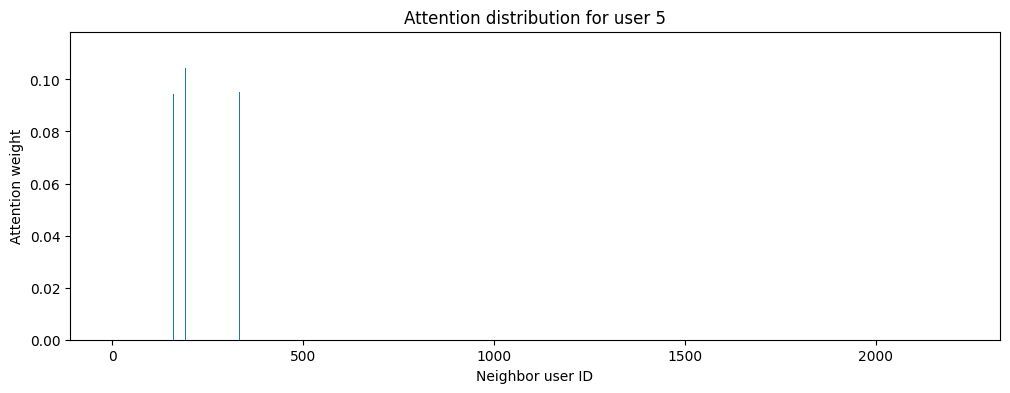

In [ ]:
import matplotlib.pyplot as plt

u = 5
plt.figure(figsize=(12, 4))
plt.bar(range(len(weights)), weights)
plt.title(f"Attention distribution for user {u}")
plt.xlabel("Neighbor user ID")
plt.ylabel("Attention weight")
plt.show()


In [ ]:
explanation = explain_recommendation(
    user_id=10,
    item_id=20,
    model=explain_model,
    A=A_denoised_torch
)

explanation


  0%|          | 0/1 [00:00<?, ?it/s]

{'social_explanations': ['Friend 317 influenced this recommendation with attention 0.1038',
  'Friend 59 influenced this recommendation with attention 0.1031',
  'Friend 380 influenced this recommendation with attention 0.1026'],
 'feature_explanations': ['Embedding dimension 60 contributed 0.0152',
  'Embedding dimension 46 contributed 0.0150',
  'Embedding dimension 41 contributed 0.0146']}

In [ ]:
shap_values = shap_explain_user(5, 20, explain_model, A_denoised_torch)
print("SHAP dimensions:", len(shap_values[0]))


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP dimensions: 64


In [ ]:
def fidelity_test(user, item, model, A):
    with torch.no_grad():
        score_original, _ = model.forward(
            torch.tensor([user], device=device),
            torch.tensor([item], device=device),
            A
        )

    # find top neighbor
    _, attn = model.propagate_users(A)
    top_neighbor = attn[user].argmax().item()

    # remove this edge (simulate)
    A2 = A.clone()
    A2[user, top_neighbor] = 0

    with torch.no_grad():
        score_removed, _ = model.forward(
            torch.tensor([user], device=device),
            torch.tensor([item], device=device),
            A2
        )

    return float(abs(score_original - score_removed))

fidelity = fidelity_test(5, 20, explain_model, A_denoised_torch)
print("Fidelity:", fidelity)


Fidelity: 0.63755863904953


**Step 2-Comprehensive Evaluation and Ablation Study**


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MFBaseline(nn.Module):
    """
    Simple Matrix Factorization:
    - user_emb: [num_users, d]
    - item_emb: [num_items, d]
    Forward signature matches SocialGCN: (user_idx, item_idx) -> (logits, _)
    """
    def __init__(self, num_users, num_items, emb_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_idx, item_idx):
        u = self.user_emb(user_idx)        # [B, d]
        i = self.item_emb(item_idx)        # [B, d]
        logits = (u * i).sum(dim=1)        # dot product
        logits += self.user_bias(user_idx).squeeze(1)
        logits += self.item_bias(item_idx).squeeze(1)
        # Return logits, second output (dummy) to match SocialGCN
        return logits, None


In [ ]:
# === Matrix Factorization Baseline Training===

# Define MF Baseline model (if not already defined)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict
import numpy as np

class MFBaseline(nn.Module):
    """
    Simple Matrix Factorization baseline.
    """
    def __init__(self, num_users, num_items, emb_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_idx, item_idx):
        u = self.user_emb(user_idx)
        i = self.item_emb(item_idx)
        logits = (u * i).sum(dim=1)
        logits += self.user_bias(user_idx).squeeze(1)
        logits += self.item_bias(item_idx).squeeze(1)
        return logits, None


# Negative sampling helper
user_seen_mf = defaultdict(set)
for u, i, r_val in train_inter:
    user_seen_mf[int(u)].add(int(i))
for u, i, r_val in val_inter:
    user_seen_mf[int(u)].add(int(i))

def sample_negatives_mf(user_id, n_neg=5):
    seen = user_seen_mf[user_id]
    negs = []
    while len(negs) < n_neg:
        j = np.random.randint(0, num_items)
        if j not in seen:
            negs.append(j)
    return negs


# BPR training loop
def run_train_epoch_bpr(model, data_loader, optimizer, n_neg=5):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in data_loader:
        u, i_pos, r_batch = batch
        u = u.to(device)
        i_pos = i_pos.to(device)

        neg_items = [sample_negatives_mf(int(x), n_neg=n_neg) for x in u.cpu().numpy()]
        i_neg = torch.tensor(neg_items, dtype=torch.long, device=device)

        optimizer.zero_grad()

        pos_logits, _ = model(u, i_pos)

        u_rep = u.unsqueeze(1).expand(-1, n_neg).reshape(-1)
        i_neg_flat = i_neg.reshape(-1)
        neg_logits, _ = model(u_rep, i_neg_flat)
        neg_logits = neg_logits.view(-1, n_neg)

        diff = pos_logits.unsqueeze(1) - neg_logits
        bpr_loss = -F.logsigmoid(diff).mean()

        bpr_loss.backward()
        optimizer.step()

        total_loss += bpr_loss.item()
        n_batches += 1

    return total_loss / max(1, n_batches)


# Initialize and train MF baseline
emb_dim = 64
mf_model = MFBaseline(num_users, num_items, emb_dim).to(device)
mf_optimizer = optim.Adam(mf_model.parameters(), lr=0.005)

num_epochs_mf = 20
for epoch in range(1, num_epochs_mf + 1):
    train_loss = run_train_epoch_bpr(mf_model, train_loader, mf_optimizer, n_neg=5)
    print(f"[MF Epoch {epoch:02d}] train_loss = {train_loss:.4f}")

print("MF baseline training complete.")


[MF Epoch 01] train_loss = 0.6915
[MF Epoch 02] train_loss = 0.6770
[MF Epoch 03] train_loss = 0.6537
[MF Epoch 04] train_loss = 0.6151
[MF Epoch 05] train_loss = 0.5578
[MF Epoch 06] train_loss = 0.4838
[MF Epoch 07] train_loss = 0.3990
[MF Epoch 08] train_loss = 0.3146
[MF Epoch 09] train_loss = 0.2398
[MF Epoch 10] train_loss = 0.1798
[MF Epoch 11] train_loss = 0.1347
[MF Epoch 12] train_loss = 0.1020
[MF Epoch 13] train_loss = 0.0789
[MF Epoch 14] train_loss = 0.0626
[MF Epoch 15] train_loss = 0.0510
[MF Epoch 16] train_loss = 0.0425
[MF Epoch 17] train_loss = 0.0357
[MF Epoch 18] train_loss = 0.0310
[MF Epoch 19] train_loss = 0.0271
[MF Epoch 20] train_loss = 0.0241
MF baseline training complete.


In [ ]:
# SocialGCN WITHOUT denoising: uses original A_norm_torch
emb_dim = 64

social_gcn_raw = SocialGCN(
    num_users=num_users,
    num_items=num_items,
    emb_dim=emb_dim,
    adj=A_norm_torch,     # <<< original adjacency
    alpha=0.6,
    dropout_p=0.25
).to(device)

gcn_raw_optimizer = optim.Adam(social_gcn_raw.parameters(), lr=0.005)

num_epochs_gnn_raw = 20  # match your denoised model epochs
n_neg = 5
mse_lambda = 0.1

for epoch in range(1, num_epochs_gnn_raw + 1):
    train_loss = run_train_epoch_multi_bpr(
        social_gcn_raw,
        train_loader,
        gcn_raw_optimizer,
        n_neg=n_neg,
        mse_lambda=mse_lambda,
    )
    print(f"[GCN-RAW Epoch {epoch:02d}] train_loss = {train_loss:.4f}")

print("SocialGCN (raw adjacency) training complete.")


[GCN-RAW Epoch 01] train_loss = 0.7064
[GCN-RAW Epoch 02] train_loss = 0.6840
[GCN-RAW Epoch 03] train_loss = 0.6018
[GCN-RAW Epoch 04] train_loss = 0.5262
[GCN-RAW Epoch 05] train_loss = 0.4936
[GCN-RAW Epoch 06] train_loss = 0.4805
[GCN-RAW Epoch 07] train_loss = 0.4665
[GCN-RAW Epoch 08] train_loss = 0.4595
[GCN-RAW Epoch 09] train_loss = 0.4492
[GCN-RAW Epoch 10] train_loss = 0.4432
[GCN-RAW Epoch 11] train_loss = 0.4397
[GCN-RAW Epoch 12] train_loss = 0.4325
[GCN-RAW Epoch 13] train_loss = 0.4259
[GCN-RAW Epoch 14] train_loss = 0.4202
[GCN-RAW Epoch 15] train_loss = 0.4170
[GCN-RAW Epoch 16] train_loss = 0.4103
[GCN-RAW Epoch 17] train_loss = 0.4039
[GCN-RAW Epoch 18] train_loss = 0.3989
[GCN-RAW Epoch 19] train_loss = 0.3861
[GCN-RAW Epoch 20] train_loss = 0.3691
SocialGCN (raw adjacency) training complete.


In [ ]:
# === FIXED IMPROVED GAT + DENOISING TRAINING (arg order corrected) ===

class ExplainableSocialGAT(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64, dropout=0.3):
        super().__init__()

        self.user_emb = nn.Embedding(num_users, emb_dim)

        # Your existing GATLayer supports only: (in_dim, out_dim, dropout)
        self.gat1 = GATLayer(emb_dim, emb_dim, dropout=dropout)
        self.gat2 = GATLayer(emb_dim, emb_dim, dropout=dropout)

        self.item_emb = nn.Embedding(num_items, emb_dim)

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

        self.dropout = nn.Dropout(dropout)

    def propagate_users(self, A):
        # user_embs: [num_users, emb_dim]
        u0 = self.dropout(self.user_emb.weight)

        # IMPORTANT: pass (features, adjacency), not (adjacency, features)
        h1, attn1 = self.gat1(u0, A)
        h1 = torch.relu(h1)
        h1 = self.dropout(h1)

        h2, attn2 = self.gat2(h1, A)
        return h2, attn2

    def forward(self, user_idx, item_idx, A):
        u_final, attn = self.propagate_users(A)
        u = u_final[user_idx]
        i = self.item_emb(item_idx)
        logits = (u * i).sum(dim=1)
        return logits, attn


# 2. Reinitialize GAT model
emb_dim = 64
explain_model = ExplainableSocialGAT(
    num_users=num_users,
    num_items=num_items,
    emb_dim=emb_dim,
    dropout=0.3
).to(device)

# 3. Better optimizer
gat_optimizer = torch.optim.Adam(
    explain_model.parameters(),
    lr=0.001,           # lower LR
    weight_decay=1e-4   # L2 regularization
)

# 4. Improved training: BPR + MSE
def run_train_epoch_gat_full(model, data_loader, optimizer, A, n_neg=4, mse_lambda=1.0):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in data_loader:
        u, i_pos, r_batch = batch
        u = u.to(device)
        i_pos = i_pos.to(device)
        r_batch = r_batch.float().to(device)

        # sample negatives
        neg_items = [sample_negatives_mf(int(x), n_neg=n_neg) for x in u.cpu().numpy()]
        i_neg = torch.tensor(neg_items, dtype=torch.long, device=device)

        optimizer.zero_grad()

        pos_logits, _ = model(u, i_pos, A)

        u_rep = u.unsqueeze(1).expand(-1, n_neg).reshape(-1)
        i_neg_flat = i_neg.reshape(-1)
        neg_logits, _ = model(u_rep, i_neg_flat, A)
        neg_logits = neg_logits.view(-1, n_neg)

        bpr_loss = -torch.log(torch.sigmoid(pos_logits.unsqueeze(1) - neg_logits)).mean()
        mse_loss = nn.MSELoss()(pos_logits, r_batch)

        loss = bpr_loss + mse_lambda * mse_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss / max(1, n_batches)


# 5. Train longer for GAT to converge properly
num_epochs_gat = 50   # recommended 40–60

for epoch in range(1, num_epochs_gat + 1):
    loss = run_train_epoch_gat_full(
        explain_model,
        train_loader,
        gat_optimizer,
        A_denoised_torch,
        n_neg=4,
        mse_lambda=1.0
    )
    if epoch % 5 == 0:
        print(f"[GAT Epoch {epoch}] loss = {loss:.4f}")

print("Improved GAT training complete.")


[GAT Epoch 5] loss = 1.1246
[GAT Epoch 10] loss = 0.8829
[GAT Epoch 15] loss = 0.6669
[GAT Epoch 20] loss = 0.6487
[GAT Epoch 25] loss = 0.6520
[GAT Epoch 30] loss = 0.6504
[GAT Epoch 35] loss = 0.6481
[GAT Epoch 40] loss = 0.6483
[GAT Epoch 45] loss = 0.6520
[GAT Epoch 50] loss = 0.6469
Improved GAT training complete.


In [ ]:
# Helper to update global embeddings used by evaluation functions
def set_embeddings_from_numpy(U, I):
    """
    Set global user_embeddings & item_embeddings for evaluation.
    U: numpy array of user embeddings, shape [num_users, dim]
    I: numpy array of item embeddings, shape [num_items, dim]
    """
    global user_embeddings, item_embeddings
    user_embeddings = U
    item_embeddings = I

In [ ]:
def evaluate_model_label(label, seen_train, seen_trainval, K=10):
    print(f"\n=== Evaluating {label} ===")

    p_val, r_val, ndcg_val = evaluate_split(
        val_inter, seen_train, k=K, rating_thresh=0.5, max_users=500
    )

    p_test, r_test, ndcg_test = evaluate_split(
        test_inter, seen_trainval, k=K, rating_thresh=0.5, max_users=500
    )

    print(f"[VAL]  P@{K}={p_val:.4f}, R@{K}={r_val:.4f}, nDCG@{K}={ndcg_val:.4f}")
    print(f"[TEST] P@{K}={p_test:.4f}, R@{K}={r_test:.4f}, nDCG@{K}={ndcg_test:.4f}")

    return {
        "model": label,
        "val_P@K": p_val,
        "val_R@K": r_val,
        "val_nDCG@K": ndcg_val,
        "test_P@K": p_test,
        "test_R@K": r_test,
        "test_nDCG@K": ndcg_test,
    }

In [ ]:
explain_model.eval()
with torch.no_grad():
    U_gat, _ = explain_model.propagate_users(A_denoised_torch)
    U_gat = U_gat.cpu().numpy()
    I_gat = explain_model.item_emb.weight.detach().cpu().numpy()

set_embeddings_from_numpy(U_gat, I_gat)
res_gat = evaluate_model_label("GAT_denoised_improved", seen_train, seen_trainval, K=10)
res_gat



=== Evaluating GAT_denoised_improved ===
[VAL]  P@10=0.0020, R@10=0.0078, nDCG@10=0.0064
[TEST] P@10=0.0016, R@10=0.0046, nDCG@10=0.0051


{'model': 'GAT_denoised_improved',
 'val_P@K': 0.002,
 'val_R@K': 0.007833333333333333,
 'val_nDCG@K': 0.006379735158285979,
 'test_P@K': 0.0016,
 'test_R@K': 0.004619047619047619,
 'test_nDCG@K': 0.005064055765690183}

In [ ]:
import numpy as np
import torch

# --- Helper: score for a single (user, item) ---
def score_user_item(model, A, user_id, item_id):
    model.eval()
    with torch.no_grad():
        u = torch.tensor([user_id], dtype=torch.long, device=device)
        i = torch.tensor([item_id], dtype=torch.long, device=device)
        logit, _ = model(u, i, A)
    return logit.item()

# --- Fidelity: change in score after removing top-attention neighbor ---
def fidelity_for_pair(model, A, user_id, item_id):
    model.eval()
    with torch.no_grad():
        # Get attention matrix once
        _, attn = model.propagate_users(A)     # attn: [num_users, num_users]
        attn_row = attn[user_id]               # [num_users]

        # If this user has no neighbors, fidelity = 0
        if attn_row.sum() <= 0:
            return 0.0

        # Find most influential neighbor
        top_neighbor = torch.argmax(attn_row).item()

        # Original score
        orig = score_user_item(model, A, user_id, item_id)

        # Remove that edge in a copy of A
        A_mod = A.clone()
        A_mod[user_id, top_neighbor] = 0.0
        A_mod[top_neighbor, user_id] = 0.0  # assume undirected

        # New score
        new = score_user_item(model, A_mod, user_id, item_id)

    return abs(orig - new)

def average_fidelity(model, A, n_users=30, n_items_per_user=3):
    users = np.random.choice(num_users, size=min(n_users, num_users), replace=False)
    scores = []

    for u in users:
        items = np.random.randint(0, num_items, size=n_items_per_user)
        for it in items:
            f = fidelity_for_pair(model, A, int(u), int(it))
            scores.append(f)

    scores = np.array(scores)
    return float(scores.mean()), float(scores.std()), len(scores)

avg_fid, std_fid, n_pairs = average_fidelity(explain_model, A_denoised_torch,
                                             n_users=30, n_items_per_user=3)
print(f"Average fidelity (|Δscore| after removing top neighbor) over {n_pairs} pairs:")
print(f"  {avg_fid:.4f} ± {std_fid:.4f}")


Average fidelity (|Δscore| after removing top neighbor) over 90 pairs:
  0.0075 ± 0.0075


In [ ]:
def attention_sparsity(model, A, top_k=5):
    model.eval()
    with torch.no_grad():
        _, attn = model.propagate_users(A)   # [num_users, num_users]
        attn_np = attn.detach().cpu().numpy()

    masses = []
    for row in attn_np:
        row_sum = row.sum()
        if row_sum <= 0:
            continue
        sorted_row = np.sort(row)[::-1]
        top_mass = sorted_row[:top_k].sum() / row_sum
        masses.append(top_mass)

    masses = np.array(masses)
    return float(masses.mean()), float(masses.std()), len(masses)

avg_mass_top5, std_mass_top5, n_users_attn = attention_sparsity(
    explain_model, A_denoised_torch, top_k=5
)
print(f"Average fraction of attention mass in top-5 neighbors (over {n_users_attn} users):")
print(f"  {avg_mass_top5:.4f} ± {std_mass_top5:.4f}")


Average fraction of attention mass in top-5 neighbors (over 2215 users):
  0.4648 ± 0.1260


In [ ]:
import pandas as pd

def diversity_personalization_for_current_embeddings(label, top_k=10):
    # sample users for coverage
    user_sample = np.random.choice(num_users, size=min(300, num_users), replace=False)
    unique_items, item_counter = coverage(user_sample, top_k=top_k)
    coverage_ratio = unique_items / num_items

    # sample users for personalization
    user_sample_small = np.random.choice(num_users, size=min(80, num_users), replace=False)
    jac_sim = personalization_score(user_sample_small, top_k=top_k)
    personalization = 1 - jac_sim

    print(f"\n=== {label} ===")
    print(f"Coverage@{top_k}: {unique_items} / {num_items} = {coverage_ratio:.4f}")
    print(f"Avg Jaccard similarity: {jac_sim:.4f}")
    print(f"Personalization (1 - Jaccard): {personalization:.4f}")

    return {
        "model": label,
        "coverage@K": coverage_ratio,
        "personalization@K": personalization
    }

div_results = []

# 1) MF baseline
with torch.no_grad():
    U_mf = mf_model.user_emb.weight.detach().cpu().numpy()
    I_mf = mf_model.item_emb.weight.detach().cpu().numpy()
set_embeddings_from_numpy(U_mf, I_mf)
div_results.append(diversity_personalization_for_current_embeddings("MF_baseline", top_k=10))

# 2) SocialGCN_rawA
with torch.no_grad():
    U_raw = social_gcn_raw.propagate_users().cpu().numpy()
    I_raw = social_gcn_raw.item_emb.weight.detach().cpu().numpy()
set_embeddings_from_numpy(U_raw, I_raw)
div_results.append(diversity_personalization_for_current_embeddings("SocialGCN_rawA", top_k=10))

# 3) GAT_denoised_improved
with torch.no_grad():
    U_gat, _ = explain_model.propagate_users(A_denoised_torch)
    U_gat = U_gat.cpu().numpy()
    I_gat = explain_model.item_emb.weight.detach().cpu().numpy()
set_embeddings_from_numpy(U_gat, I_gat)
div_results.append(diversity_personalization_for_current_embeddings("GAT_denoised_improved", top_k=10))

diversity_df = pd.DataFrame(div_results)
diversity_df



=== MF_baseline ===
Coverage@10: 1401 / 16790 = 0.0834
Avg Jaccard similarity: 0.0231
Personalization (1 - Jaccard): 0.9769

=== SocialGCN_rawA ===
Coverage@10: 137 / 16790 = 0.0082
Avg Jaccard similarity: 0.2755
Personalization (1 - Jaccard): 0.7245

=== GAT_denoised_improved ===
Coverage@10: 12 / 16790 = 0.0007
Avg Jaccard similarity: 0.9827
Personalization (1 - Jaccard): 0.0173


,model,coverage@K,personalization@K
0,MF_baseline,0.083443,0.976865
1,SocialGCN_rawA,0.008160,0.724498
2,GAT_denoised_improved,0.000715,0.017252


In [ ]:
!pip install networkx

Ego user: 10, #neighbors: 10


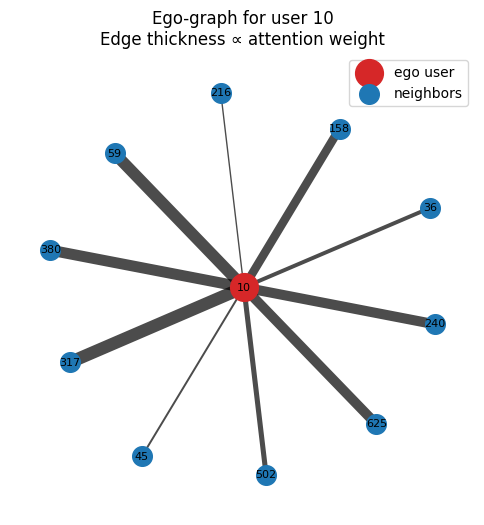

In [ ]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Choose a user to visualize
ego_user = 10   # change this to any user id (0 .. num_users-1)

# Get attention matrix from the trained GAT + denoising model
explain_model.eval()
with torch.no_grad():
    _, attn = explain_model.propagate_users(A_denoised_torch)   # [num_users, num_users]
    attn_np = attn.detach().cpu().numpy()

# Get neighbors in the denoised graph
A_np = A_denoised_torch.detach().cpu().numpy()
neighbors = np.where(A_np[ego_user] > 0)[0]

print(f"Ego user: {ego_user}, #neighbors: {len(neighbors)}")

# Build ego graph
G = nx.Graph()
G.add_node(ego_user)

edge_widths = []
for v in neighbors:
    w = attn_np[ego_user, v]
    if w <= 0:
        continue
    G.add_edge(ego_user, v, weight=w)
    edge_widths.append(w)

if len(G.edges) == 0:
    print("This user has no neighbors with positive attention. Try another ego_user.")
else:
    # Normalize edge widths for plotting
    weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
    if weights.max() > 0:
        widths = 1 + 8 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)
    else:
        widths = [1 for _ in weights]

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, nodelist=[ego_user], node_color="tab:red", node_size=400, label="ego user")
    other_nodes = [n for n in G.nodes() if n != ego_user]
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color="tab:blue", node_size=200, label="neighbors")

    nx.draw_networkx_edges(G, pos, width=widths, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f"Ego-graph for user {ego_user}\nEdge thickness ∝ attention weight")
    plt.axis("off")
    plt.legend(scatterpoints=1)
    plt.show()


In [ ]:
from tabulate import tabulate
import pandas as pd

# Build records with rank included
records = []
for v in neighbors:
    w = float(attn_np[ego_user, v])
    if w > 0:
        records.append((v, w))

# Sort by attention descending
records = sorted(records, key=lambda x: x[1], reverse=True)

# Create table rows: Rank, Ego User, Neighbor, Attention Score
table_rows = []
for rank, (nbr, att) in enumerate(records, 1):
    table_rows.append([rank, ego_user, nbr, f"{att:.4f}"])

# Column headers
headers = ["Rank", "User ID", "Neighbor ID", "Attention Score"]

# Print using tabulate
print("\n=== Ranked Attention Weights ===\n")
print(tabulate(table_rows, headers=headers, tablefmt="psql"))



=== Ranked Attention Weights ===

+--------+-----------+---------------+-------------------+
|   Rank |   User ID |   Neighbor ID |   Attention Score |
|--------+-----------+---------------+-------------------|
|      1 |        10 |           317 |            0.1038 |
|      2 |        10 |            59 |            0.1031 |
|      3 |        10 |           380 |            0.1026 |
|      4 |        10 |           240 |            0.1019 |
|      5 |        10 |           625 |            0.1018 |
|      6 |        10 |           158 |            0.1007 |
|      7 |        10 |           502 |            0.0981 |
|      8 |        10 |            36 |            0.0972 |
|      9 |        10 |            45 |            0.0957 |
|     10 |        10 |           216 |            0.0952 |
+--------+-----------+---------------+-------------------+


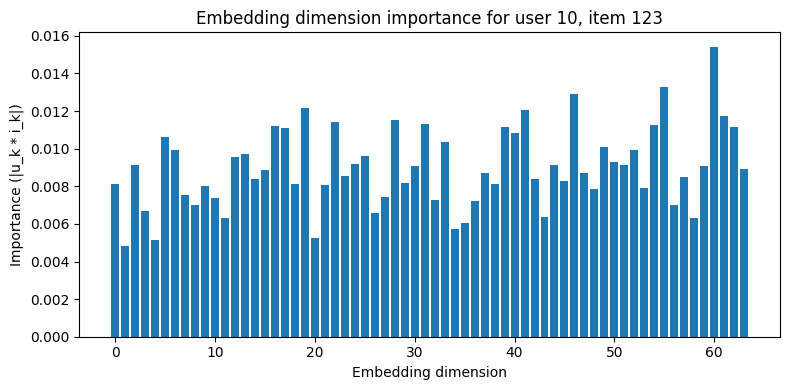

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Choose a user and an item (e.g., from that user's top-K recommendations)
user_id = ego_user      # reuse same user as ego-graph
item_id = 123           # change this to some item id you care about (0..num_items-1)

# Get final user embeddings from GAT + denoising
explain_model.eval()
with torch.no_grad():
    U_gat, _ = explain_model.propagate_users(A_denoised_torch)   # [num_users, d]
    u_vec = U_gat[user_id].detach().cpu().numpy()                # [d]
    i_vec = explain_model.item_emb.weight[item_id].detach().cpu().numpy()  # [d]

# Dimension-wise contribution (absolute)
dim_contrib = np.abs(u_vec * i_vec)  # [d]

dims = np.arange(len(dim_contrib))

plt.figure(figsize=(8, 4))
plt.bar(dims, dim_contrib)
plt.xlabel("Embedding dimension")
plt.ylabel("Importance (|u_k * i_k|)")
plt.title(f"Embedding dimension importance for user {user_id}, item {item_id}")
plt.tight_layout()
plt.show()


In [ ]:
u = 57
with torch.no_grad():
    _, attn = explain_model.propagate_users(A_denoised_torch)

weights = attn[u].detach().cpu().numpy()
print("Sum of attention:", weights.sum())
print("Top 5 neighbors:", weights.argsort()[::-1][:5])
print("Top 5 weights:", weights[weights.argsort()[::-1][:5]])

Sum of attention: 1.0000001
Top 5 neighbors: [333 167 162 191 163]
Top 5 weights: [0.10271472 0.10216971 0.10138524 0.10128187 0.1011875 ]


In [ ]:
import pandas as pd
import torch

# --- Make sure helper exists ---
def set_embeddings_from_numpy(U, I):
    global user_embeddings, item_embeddings
    user_embeddings = U
    item_embeddings = I

def evaluate_model_label(label, seen_train, seen_trainval, K=10):
    print(f"\n=== Evaluating {label} ===")

    p_val, r_val, ndcg_val = evaluate_split(
        val_inter, seen_train, k=K, rating_thresh=0.5, max_users=500
    )
    p_test, r_test, ndcg_test = evaluate_split(
        test_inter, seen_trainval, k=K, rating_thresh=0.5, max_users=500
    )

    print(f"[VAL]  P@{K}={p_val:.4f}, R@{K}={r_val:.4f}, nDCG@{K}={ndcg_val:.4f}")
    print(f"[TEST] P@{K}={p_test:.4f}, R@{K}={r_test:.4f}, nDCG@{K}={ndcg_test:.4f}")

    return {
        "model": label,
        "val_P@K": p_val,
        "val_R@K": r_val,
        "val_nDCG@K": ndcg_val,
        "test_P@K": p_test,
        "test_R@K": r_test,
        "test_nDCG@K": ndcg_test,
    }


# ============================================================
# FINAL EVALUATION: MF vs SocialGCN vs GAT (Denoised)
# ============================================================

results = []

# ---------- MF ----------
mf_model.eval()
with torch.no_grad():
    U_mf = mf_model.user_emb.weight.detach().cpu().numpy()
    I_mf = mf_model.item_emb.weight.detach().cpu().numpy()

set_embeddings_from_numpy(U_mf, I_mf)
results.append(evaluate_model_label("MF Baseline", seen_train, seen_trainval, K=10))


# ---------- SocialGCN Raw ----------
social_gcn_raw.eval()
with torch.no_grad():
    U_raw = social_gcn_raw.propagate_users().cpu().numpy()
    I_raw = social_gcn_raw.item_emb.weight.detach().cpu().numpy()

set_embeddings_from_numpy(U_raw, I_raw)
results.append(evaluate_model_label("SocialGCN Raw", seen_train, seen_trainval, K=10))


# ---------- GAT + Denoising ----------
explain_model.eval()
with torch.no_grad():
    U_gat, _ = explain_model.propagate_users(A_denoised_torch)
    U_gat = U_gat.cpu().numpy()
    I_gat = explain_model.item_emb.weight.detach().cpu().numpy()

set_embeddings_from_numpy(U_gat, I_gat)
results.append(evaluate_model_label("GAT Denoised", seen_train, seen_trainval, K=10))

# Final results table
ablation_df = pd.DataFrame(results)
ablation_df


=== Evaluating MF Baseline ===
[VAL]  P@10=0.0046, R@10=0.0209, nDCG@10=0.0202
[TEST] P@10=0.0050, R@10=0.0235, nDCG@10=0.0236

=== Evaluating SocialGCN Raw ===
[VAL]  P@10=0.0048, R@10=0.0285, nDCG@10=0.0241
[TEST] P@10=0.0042, R@10=0.0231, nDCG@10=0.0201

=== Evaluating GAT Denoised ===
[VAL]  P@10=0.0020, R@10=0.0078, nDCG@10=0.0064
[TEST] P@10=0.0016, R@10=0.0046, nDCG@10=0.0051


,model,val_P@K,val_R@K,val_nDCG@K,test_P@K,test_R@K,test_nDCG@K
0,MF Baseline,0.0046,0.020920,0.02018,0.0050,0.023475,0.023584
1,SocialGCN Raw,0.0048,0.028483,0.02412,0.0042,0.023119,0.020148
2,GAT Denoised,0.0020,0.007833,0.00638,0.0016,0.004619,0.005064


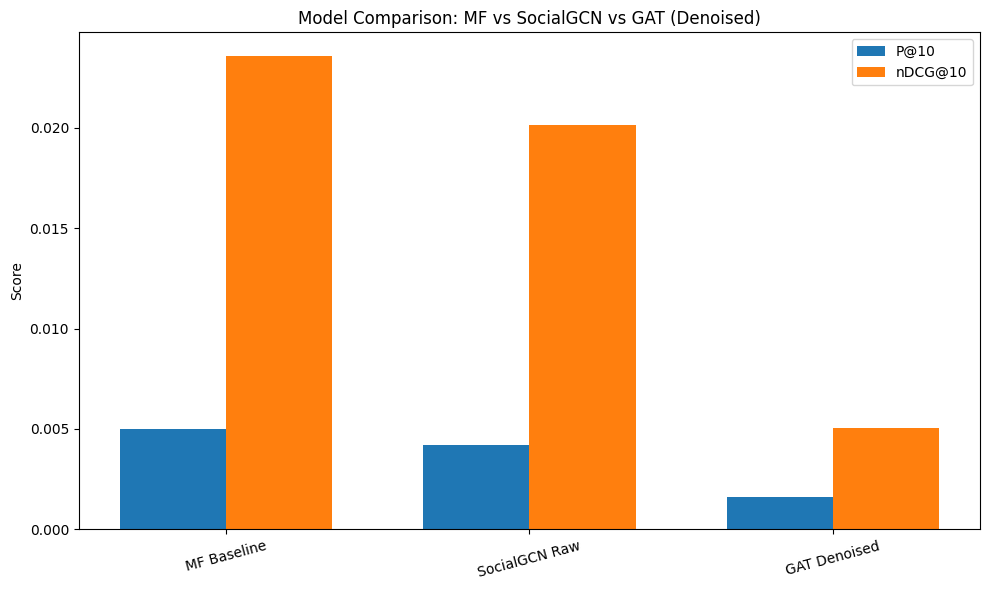

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract results from the evaluation table
models = list(ablation_df["model"])
p_at_10 = list(ablation_df["test_P@K"])
ndcg_10 = list(ablation_df["test_nDCG@K"])

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, p_at_10, width, label='P@10')
plt.bar(x + width/2, ndcg_10, width, label='nDCG@10')

plt.xticks(x, models, rotation=15)
plt.ylabel("Score")
plt.title("Model Comparison: MF vs SocialGCN vs GAT (Denoised)")
plt.legend()
plt.tight_layout()
plt.show()